# prepare

In [97]:
import graphviz as gz
import pandas   as pd
import numpy    as np
import cvxpy    as cp
import matplotlib.pyplot as plt
import statsmodels.api  as stm
import statsmodels.tsa.api as smt
import scipy.stats as scs
import seaborn as sns
import sklearn.decomposition as sdc
from scipy import linalg
from collections import namedtuple
from talib import abstract as ab
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

## graphviz

1. 安装graphviz的安装文件（从官网下载）
2. 将安装程序的bin目录加入到path的环境变量里面（window）
3. pip install graphvize

# MFM基本理论
多因子模型:Multiple-Factor Model, 简称：MFM

## 主动定量组合管理

### 拓扑

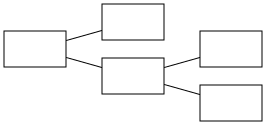

In [2]:
g=gz.Graph()
g.attr(rankdir='LR')
g.attr('node', shape='box')
g.node('AA','组合管理')
g.node('BA','被动管理')
g.node('BB','主动管理')
g.node('CA','定性管理')
g.node('CB','定量管理')

g.edges([('AA','BA'),('AA','BB'),('BB','CA'),('BB','CB'),])
g

### 对比

|对比|准则 |定量管理 |定性管理|
|-|-|-|-|
|优势| 客观性| 高| 低
|优势|宽度| 高| 低|
|优势|行为失误| 低| 高|
|优势|可复制性| 高| 低|
|优势|成本| 低| 高|
|优势|风险控制| 高| 低|
|劣势| 定性投入| 低| 高
|劣势|历史数据依赖性| 高| 低|
|劣势|数据挖掘| 高| 低|
|劣势|反应性| 低| 高|

### 定量管理的七条准则：

定量管理的关注点是因子（共性），而非股票（个性）。

1. 市场大多是有效的；
2. 纯套利机会不存在；
3. 定量分析创造统计上的套利机会；
4. 定量分析以有效的方式结合所有可获得的信息；
5. 定量模型应该基于合理的经济理论；
6. 定量模型应该反映持续和稳定的模式；
7. 证券投资组合与基准的偏差只有当不确定性足够小时才是合理的。

### MFM模型

$\Large\tilde{r_j}=\sum_{k=1}^K{\underbrace{X_{jk}\tilde{f_k}}_{定量管理}+\underbrace{\tilde{\mu}}_{定性管理}}$

## $\alpha$：阿尔法
$\alpha$:超越平均水平或者基准的卓越表现

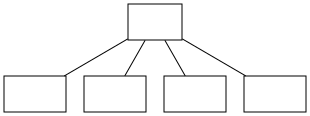

In [3]:
g=gz.Graph()
g.attr(rankdir='TB')
g.attr('node', shape='box')
g.node('AA','阿尔法')
g.node('BA','收益预测')
g.node('BB','风险控制')
g.node('BC','过程控制')
g.node('BD','成本控制')

g.edges([('AA','BA'),('AA','BB'),('AA','BC'),('AA','BD'),])
g

## MFM

### 分类

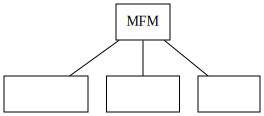

In [4]:
g=gz.Graph()
g.attr(rankdir='TB')
g.attr('node', shape='box')
g.node('AA','MFM')
g.node('BA','宏观经济因子')
g.node('BB','基本面因子')
g.node('BC','统计因子')

g.edges([('AA','BA'),('AA','BB'),('AA','BC'),])
g

### 多因子模型的风险分解

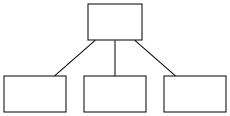

In [5]:
g=gz.Graph()
g.attr(rankdir='TB')
g.attr('node', shape='box')
g.node('AA','风险')
g.node('BA','市场风险')
g.node('BB','行业风险')
g.node('BC','风格风险')
g.edges([('AA','BA'),('AA','BB'),('AA','BC'),])
g

风格因子：
1. 估值因子
2. 成长因子
3. 财务质量因子
4. 杠杆因子
5. 规模因子
6. 动量因子
7. 波动率因子
8. 换手率因子
9. 改进的动量因子
10. 分析师情绪因子
11. 股东因子
12. 技术因子

# 构建流程实践

## 流程图

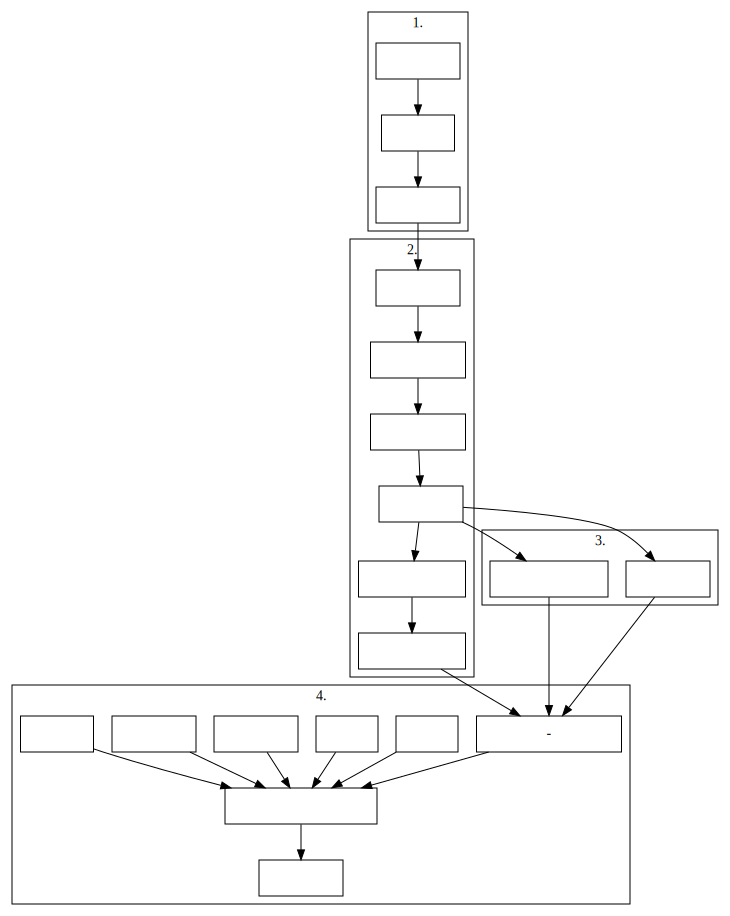

In [6]:
g=gz.Digraph()
g.attr('node', shape='box')
g.attr(rankdir='TB', )
with g.subgraph(name='cluster_0',) as c:
    c.edges([
        ('基础数据采集','数据标准化'),
        ('数据标准化','有效因子识别'),
    ])
    c.attr(label='1. 准备工作')
with g.subgraph(name='cluster_1') as c:
    c.edges([
        ('大类因子分析','因子共线性分析'),
        ('因子共线性分析','残差异方差分析'),
        ('残差异方差分析','多元线性回归'),
        ('多元线性回归','估计因子预期收益'),
        ('估计因子预期收益','计算股票预期收益'),
    ])
    c.attr(label='2. 收益模型')
with g.subgraph(name='cluster_2') as c:
    c.node('因子收益协方差矩阵')
    c.node('残差风险估计')
    c.attr(label='3. 风险模型')
with g.subgraph(name='cluster_3') as c:
    c.edges([
        ('预期风险-收益基础数据集','二次规划求解组合权重分配'),
        ('收益目标','二次规划求解组合权重分配'),
        ('风险目标','二次规划求解组合权重分配'),
        ('行业权重约束','二次规划求解组合权重分配'),
        ('因子暴露约束','二次规划求解组合权重分配'),
        ('个股上下限','二次规划求解组合权重分配'),
        ('二次规划求解组合权重分配','模拟业绩回溯'),
    ])
    c.attr(label='4. 优化模型')
    
g.edges([
    ('有效因子识别','大类因子分析'),
    ('多元线性回归','因子收益协方差矩阵'),
    ('多元线性回归','残差风险估计'),
    ('因子收益协方差矩阵','预期风险-收益基础数据集'),
    ('残差风险估计','预期风险-收益基础数据集'),
    ('计算股票预期收益','预期风险-收益基础数据集'),
])
g

## 准备工作

### 基础数据采集 

In [7]:
h5=pd.HDFStore('data/data.h5','r')

In [8]:
h5.keys()

['/fac',
 '/ind_close',
 '/ind_info',
 '/inx_close',
 '/obj_close',
 '/obj_cls',
 '/obj_weight']

In [9]:
# 沪深300指数收盘价
h5['inx_close'].head()

,instrument,date,s_dq_close
0,000300.SHA,2019-01-02,2969.5353
1,000300.SHA,2019-01-03,2964.8421
2,000300.SHA,2019-01-04,3035.8741
3,000300.SHA,2019-01-07,3054.3030
4,000300.SHA,2019-01-08,3047.7035


In [10]:
# 行业指数收盘价
h5['ind_close'].head()

,instrument,date,s_dq_close
0,801880.SI,2019-01-02,3364.27
1,801740.SI,2019-01-02,894.03
2,801210.SI,2019-01-02,4735.80
3,801200.SI,2019-01-02,2964.57
4,801750.SI,2019-01-02,3150.27


In [11]:
# 行业指数信息，指数代码、行业代码、行业名称
h5['ind_info']

,industriesalias,industriesname,memo
356,801080.SI,电子,270000
968,801770.SI,通信,730000
1067,801040.SI,钢铁,230000
1084,801180.SI,房地产,430000
1661,801890.SI,机械设备,640000
2164,801720.SI,建筑装饰,620000
2833,801110.SI,家用电器,330000
3360,801780.SI,银行,480000
4289,801010.SI,农林牧渔,110000
4573,801200.SI,商业贸易,450000


In [12]:
# 股票的价格信息
h5['obj_close'].head()

,instrument,date,s_dq_adjclose
0,600518.SHA,2019-01-02,372.15
1,600549.SHA,2019-01-02,153.67
2,600570.SHA,2019-01-02,724.17
3,600023.SHA,2019-01-02,7.23
4,000786.SZA,2019-01-02,142.95


In [13]:
# 股票所属行业信息
h5['obj_cls'].head()

,date,instrument,industry_sw_level1
0,2019-03-04,600415.SHA,450000
1,2019-03-04,600299.SHA,220000
2,2019-03-04,600309.SHA,220000
3,2019-03-04,600660.SHA,280000
4,2019-03-04,600177.SHA,430000


In [14]:
# 沪深300指数成分股的权重信息
h5['obj_weight'].head()

,date,instrument,weight
401,2019-01-02,002241.SZA,0.001426
402,2019-01-02,002230.SZA,0.003842
403,2019-01-02,002179.SZA,0.001418
404,2019-01-02,002153.SZA,0.000884
405,2019-01-02,002146.SZA,0.001472


### 数据标准化处理
由于各个因子的量纲不一致，为方便进行比较和回归，需要对因子进行标准化处理。对因子进行标准化处理主要有两种方式：

#### 两种方法：
1. 直接对因子载荷原始值进行标准化；
    1. 优点：保留因子载荷之间的分布关系；
    2. 缺点：回归的时候会受到极值的影响；
2. 首先将因子载荷原始值转换为排序值，然后再进行标准化
    1. 容易看出因子载荷与收益率之间的相关性关系；

#### 极值处理算法

##### mad
MAD（mean absolute deviation）又称为绝对值差中位数法，是一种先需计算所有因子与平均值之间的距离总和来检测离群值的方法，
>$\tilde{x_i}=\left\{\begin{matrix}
x_m+nd_{mad}& if\ \ x_i>x_m+nd_{mad} & \\ 
x_m-nd_{mad}& if\ \ x_i<x_m-nd_{mad} & \\
x_i& else
\end{matrix}\right.\\
x_m:序列x_i的中位数\\
d_{mad}:序列|x_i-x_m|的中位值\\
\tilde{x_i}:x_i去极值修正后的值\\
$

In [15]:
def f_mad(x:pd.Series,n:int=5)->pd.Series:
    xm=x.median()
    dmn=(x-xm).abs().median()*n
    return x.clip(lower=xm-dmn,upper=xm+dmn)

##### 3$\sigma$
3$\sigma$法又称为标准差法。
>$\tilde{x_i}=\left\{\begin{matrix}
x_m+n\sigma& if\ \ x_i>x_m+n\sigma & \\ 
x_m-n\sigma& if\ \ x_i<x_m-n\sigma & \\
x_i& else
\end{matrix}\right.\\
x_m:序列x_i的\color{Red}{均值}\\
\sigma:序列x_i的标准差\\
\tilde{x_i}:x_i去极值修正后的值\\
$


In [16]:
def f_sigma(x:pd.Series,n:int=5)->pd.Series:
    xm=x.mean()
    simgma_n=x.std(ddof=1)*n
    return x.clip(lower=xm-simgma_n,upper=xm+simgma_n)

##### 百分位法
将因子值进行升序的排序，对排位百分位高于或低于50%+n的因子值，进行极值靠档调整。

In [17]:
def f_quantile(x:pd.Series,n:float=.99)->pd.Series:
    y=x.quantile(q=[1-n,n])
    return x.clip(lower=y.iloc[0],upper=y.iloc[-1])

##### 排序法

In [18]:
def f_rank(x:pd.Series,)->pd.Series:
    return x.rank(axis=0,)

#### 标准化:

##### z_score标准化
将数据从原始分布映射到标准正态分布
>$\tilde{x_i}=\frac{x_i-\mu}{\sigma}\\
\mu:序列x_i的均值；\\
\sigma:序列x_i的标准差\\
\tilde{x_i}:序列x_i的标准化之后的值\\
$

In [19]:
def f_z_score(x:pd.Series)->pd.Series:
    std=x.std(ddof=0)
    r=x if std==.0 else (x-x.mean())/std
    return r.fillna(0)

##### max-min标准化
$x_i=\frac{x_i-x_{min}}{x_{max}-x_{min}}\times 2-1$

In [20]:
def f_max_min(x:pd.Series)->pd.Series:
    xmax=x.max()
    xmin=x.min()
    r=(x-x) if xmax==xmin else (x-xmin)/(xmax-xmin)*2-1
    return r.fillna(0)

#### 案例

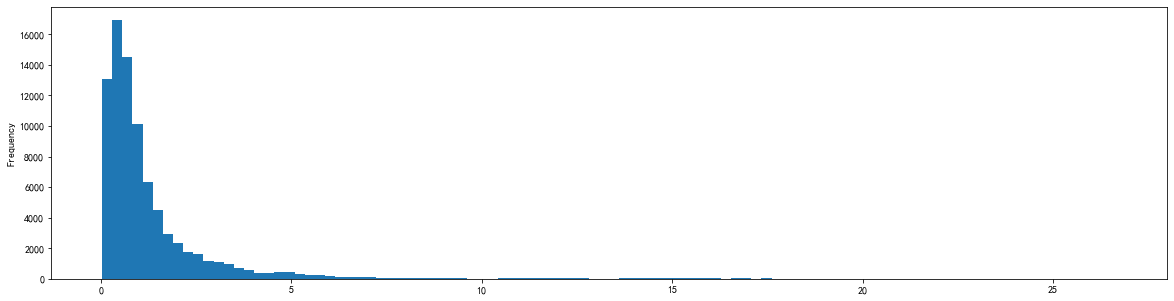

In [21]:
h5['fac']['avg_turn_60'].plot.hist(figsize=(20,5),bins=100)

In [22]:
h5['fac'].columns

Index(['avg_turn_20', 'avg_turn_240', 'avg_turn_60', 'beta_csi300_60_0',
       'close_0', 'date', 'fs_common_equity_0', 'fs_net_cash_flow_ttm_0',
       'fs_net_profit_yoy_0', 'fs_non_current_liabilities_0',
       'fs_operating_revenue_yoy_0', 'fs_total_equity_0',
       'fs_total_liability_0', 'instrument', 'market_cap_0',
       'market_cap_float_0', 'pb_lf_0', 'pe_ttm_0', 'return_60',
       'swing_volatility_60_0', 'volatility_60_0', 'west_eps_ftm_0'],
      dtype='object')

In [23]:
%%time
def _f(x:pd.DataFrame)->pd.DataFrame:
    return pd.concat(objs=[
        i(j(x.iloc[:,0])) 
        for j in  [f_mad,f_sigma,f_quantile,f_rank]
        for i in [f_z_score,f_max_min] 
    ],axis=1)
    pass
x=(h5['fac']
 .set_index('date')
 .loc[:,['beta_csi300_60_0']]
 .groupby('date')
 .apply(_f)
)

Wall time: 4.64 s


In [24]:
x.head()

,beta_csi300_60_0,beta_csi300_60_0,beta_csi300_60_0,beta_csi300_60_0,beta_csi300_60_0,beta_csi300_60_0,beta_csi300_60_0,beta_csi300_60_0
date,,,,,,,,
2019-03-04,-0.513889,-0.186634,-0.513889,-0.186634,-0.520424,-0.253032,-0.543600,-0.314815
2019-03-04,-0.642528,-0.237023,-0.642528,-0.237023,-0.650494,-0.313145,-0.735459,-0.425926
2019-03-04,0.983217,0.399791,0.983217,0.399791,0.993339,0.446564,1.076541,0.623457
2019-03-04,-1.354657,-0.515968,-1.354657,-0.515968,-1.370546,-0.645923,-1.513553,-0.876543
2019-03-04,-0.756264,-0.281574,-0.756264,-0.281574,-0.765495,-0.366294,-0.916659,-0.530864


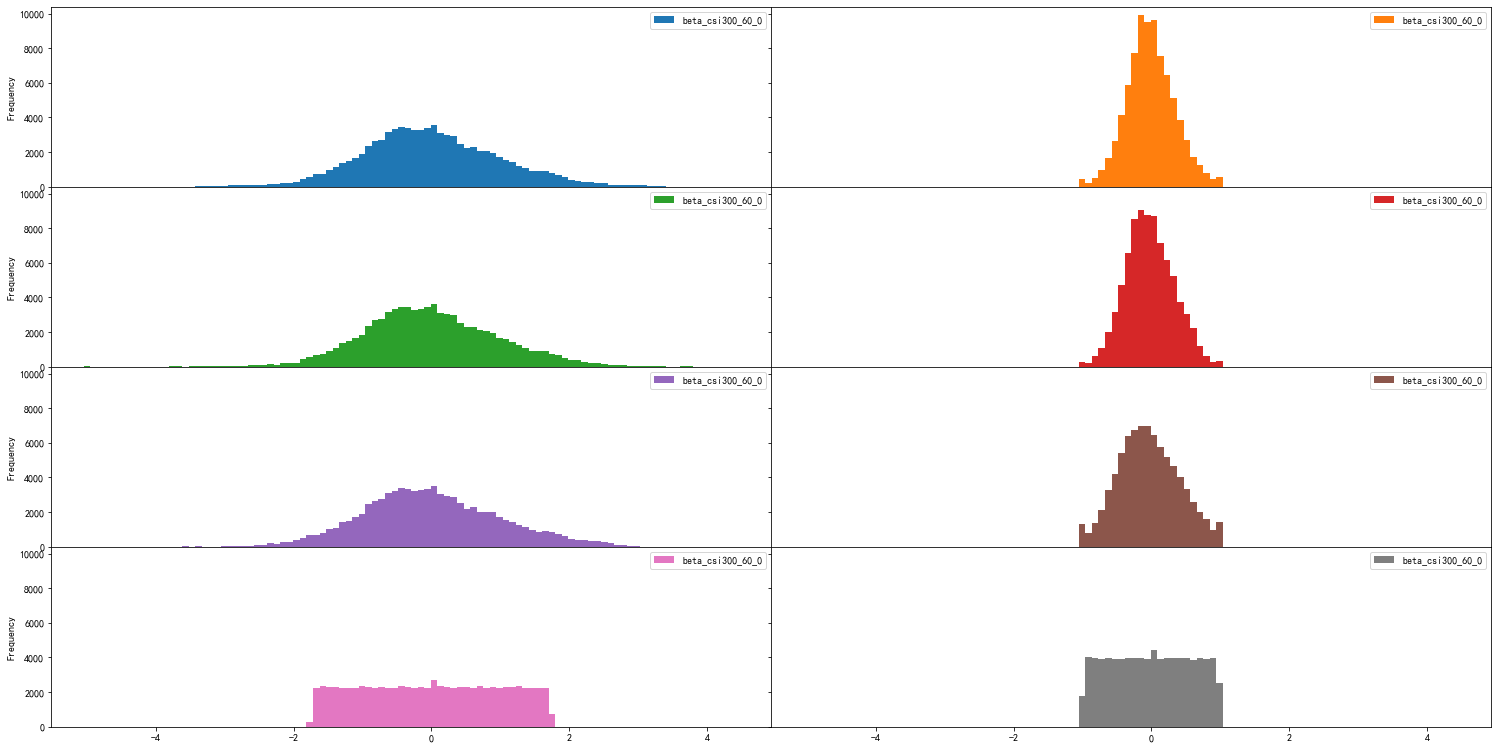

In [25]:
x.plot.hist(figsize=(20,10),bins=100,subplots=True,sharex=True,sharey=True,layout=(4,2))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

小结：
1. z_score的值域大于maxmin，所以数据分布相对分散
2. 排序法相对于其他数据分散较为均匀
3. mad和sigma的极值处理方法相差不大

### 有效因子识别

In [26]:
fac_f={
'market_cap_0':'总市值',
'market_cap_float_0':'流通市值',
'close_0':'收盘价',
'pb_lf_0':'市净率(LF)',
'pe_ttm_0':'市盈率(TTM)',
'fs_net_cash_flow_ttm_0':'经营活动现金净流量(TTM)',
'fs_net_profit_yoy_0':'归属母公司股东的净利润同比增长率',
'fs_operating_revenue_yoy_0':'营业收入同比增长率',
'fs_non_current_liabilities_0':'非流动负债',
'fs_common_equity_0':'普通股权益总额',
'fs_total_liability_0':'负债合计',
'fs_total_equity_0':'所有者权益合计',
'avg_turn_20':'过去i个交易日的平均换手率',
'avg_turn_60':'过去i个交易日的平均换手率',
'avg_turn_240':'过去i个交易日的平均换手率',
'beta_csi300_60_0':'BETA值(沪深300)',
'return_60':'过去i个交易日的收益',
'volatility_60_0':'波动率',
'swing_volatility_60_0':'振幅波动率',
'west_eps_ftm_0':'一致预测每股收益（未来12个月）',
}

In [27]:
h5['fac'].columns

Index(['avg_turn_20', 'avg_turn_240', 'avg_turn_60', 'beta_csi300_60_0',
       'close_0', 'date', 'fs_common_equity_0', 'fs_net_cash_flow_ttm_0',
       'fs_net_profit_yoy_0', 'fs_non_current_liabilities_0',
       'fs_operating_revenue_yoy_0', 'fs_total_equity_0',
       'fs_total_liability_0', 'instrument', 'market_cap_0',
       'market_cap_float_0', 'pb_lf_0', 'pe_ttm_0', 'return_60',
       'swing_volatility_60_0', 'volatility_60_0', 'west_eps_ftm_0'],
      dtype='object')

有效因子应该满足两个条件：
1. 第一是在逻辑上应该和收益率存在一定的相关性；
1. 第二是在实证中确实和收益率存在比较明显的相关性。

#### 单因子回归确定每个因子每期的因子收益
市场风险、行业风险、风格风险是影响股票收益最主要的三种因素，在验证风格因子有效性时，必须考虑市场因子和行业因子的影响。对于市场因子和行业因子的处理方式有两种：
1. 市场因子和行业因子同时纳入模型；
2. 仅纳入行业因子，而将市场因子包含在行业因子中。

单因子回归模型：
>$\large\tilde{r_j^t}=\sum_{s=1}^S{X_{js}^t\tilde{f_s^t}}+X_{jk}^t\tilde{f_k^t}+\tilde{u_j^t}\\
\tilde{r_j^t}:股票𝑗在第𝑡期的收益率\\
X_{js}^t:股票𝑗在第𝑡期在行业𝑠上的暴露\\
\tilde{f_s^t}:行业𝑠在第𝑡期的收益率\\
X_{jk}^t:股票𝑗在第𝑡期在因子𝑘上的暴露\\
\tilde{f_k^t}:因子𝑘在第𝑡期的收益率
$

In [28]:
# 收益率
a=h5['obj_close'].set_index(['date','instrument']).groupby('instrument').apply(lambda i:np.log(i).diff().fillna(0))
assert a.isna().sum().sum()==0

In [29]:
# 行业哑变量
b=pd.get_dummies(data=
    h5['obj_cls']
    .merge(right=h5['ind_info'],left_on='industry_sw_level1',right_on='memo',how='outer')
    .loc[:,['date','instrument','industriesname']],
               columns=['industriesname'],
               prefix='',prefix_sep='',
              ).set_index(['date','instrument'])

In [30]:
%%time
# 因子,对于单个标的ffill填充，截面标准化处理
c=(
    h5['fac']
    .set_index(['date','instrument'])
    .groupby('instrument')
    .apply(lambda i:i.fillna(method='ffill'))
    .groupby('date')
    .apply(lambda i:i.apply(lambda j:f_z_score(f_mad(j)),axis=0))
)

Wall time: 18.9 s


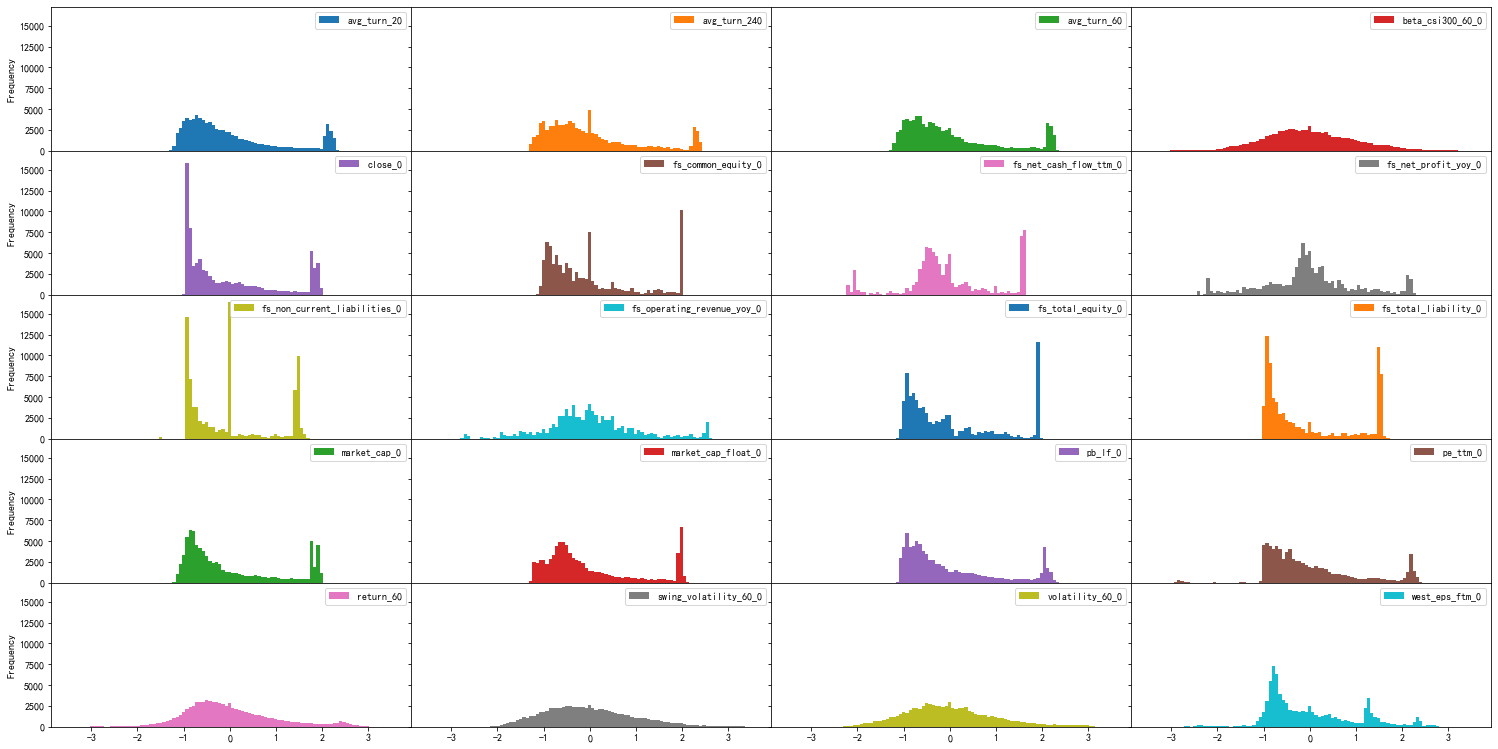

In [31]:
c.plot.hist(figsize=(20,10),bins=100,subplots=True,sharex=True,sharey=True,layout=(5,4))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

In [32]:
[i.shape for i in (a,b,c)]

[(96594, 1), (84115, 28), (83761, 20)]

In [33]:
x=pd.concat(objs=(a,b,c),join='inner',axis=1).sort_index(axis=0,level=0)
x.shape

(83761, 49)

In [34]:
x.head()

s_dq_adjclose  交通运输  休闲服务  传媒  公用事业  农林牧渔  化工  医药生物  \
date       instrument                                                        
2019-03-04 000001.SZA       0.017867     0     0   0     0     0   0     0   
           000002.SZA       0.039842     0     0   0     0     0   0     0   
           000063.SZA       0.019328     0     0   0     0     0   0     0   
           000069.SZA       0.025434     0     0   0     0     0   0     0   
           000100.SZA       0.048214     0     0   0     0     0   0     0   

                       商业贸易  国防军工  ...  fs_total_equity_0  \
date       instrument              ...                      
2019-03-04 000001.SZA     0     0  ...           1.939115   
           000002.SZA     0     0  ...           1.939115   
           000063.SZA     0     0  ...          -0.115937   
           000069.SZA     0     0  ...           0.928633   
           000100.SZA     0     0  ...           0.556949   

                       fs_total_liability_0  market_cap_0  market_cap_float_0  \
date       instrument                                                           
2019-03-04 000001.SZA              1.513909      1.735560            1.987411   
           000002.SZA              1.513909      1.735560            1.987411   
           000063.SZA              0.366676      1.512597            1.363019   
           000069.SZA              1.513909     -0.149966           -0.011517   
           000100.SZA              0.894358     -0.444132           -0.165871   

                        pb_lf_0  pe_ttm_0  return_60  swing_volatility_60_0  \
date       instrument                                                         
2019-03-04 000001.SZA -0.947311 -0.850419   0.497739              -0.362054   
           000002.SZA -0.324620 -0.781435  -0.343140              -0.835004   
           000063.SZA  1.199468 -2.062692   2.024203               1.181193   
           000069.SZA -0.911255 -0.955685  -0.265474              -0.656485   
           000100.SZA -0.689294 -0.618485   1.261894               1.212345   

                       volatility_60_0  west_eps_ftm_0  
date       instrument                                   
2019-03-04 000001.SZA        -0.252275        0.556790  
           000002.SZA        -0.442679        2.487076  
           000063.SZA         1.165053       -2.447568  
           000069.SZA        -0.517324        0.188243  
           000100.SZA         0.643711       -0.947404  

[5 rows x 49 columns]

In [35]:
%%time
def _f(x:pd.DataFrame)->pd.DataFrame:
    y=pd.concat(
        objs=[
            stm.OLS(
                endog=x.loc[:,a.columns],
                exog =x.loc[:,b.columns.to_list()+[i]] 
            ).fit().params[-1:]
            for i in c.columns
        ]
    )
    return y
y=x.groupby('date').apply(_f)# .loc[('2019-03-04',slice(None)),:]

d:\pp\miniconda3\envs\pyqi\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


Wall time: 18.9 s


#### 因子收益率序列𝑡检验
1. t检验
>$\large t=\frac{\bar{x}-\mu}{\frac{\sigma}{\sqrt{n-1}}}\\
t:x的t统计量\\
\bar{x}:样本的均值\\
\mu:总体的均值\\
\sigma:样本的标准差\\
n:样本的容量\\
$
2. 三方面的分析:
    1. 𝑡值绝对值序列的均值
    2. 𝑡值绝对值序列大于2的比例
    3. 因子收益率$\tilde{f_k^t}$序列的𝑡值检验
3. 有效因子(就是和收益率存在很明显相关性的因子，即满足前面的𝑡的第一点和第二点)的分类(根据第三点):
    1. 收益类因子
    2. 风险类因子


In [36]:
%%time
def _f(x:pd.DataFrame)->pd.DataFrame:
    y=pd.concat(
        objs=[
            stm.OLS(
                endog=x.loc[:,a.columns],
                exog =x.loc[:,b.columns.to_list()+[i]] 
            ).fit().tvalues[-1:]
            for i in c.columns
        ]
    )
    return y
z=x.groupby('date').apply(_f)# .loc[('2019-03-04',slice(None)),:]

Wall time: 19.4 s


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

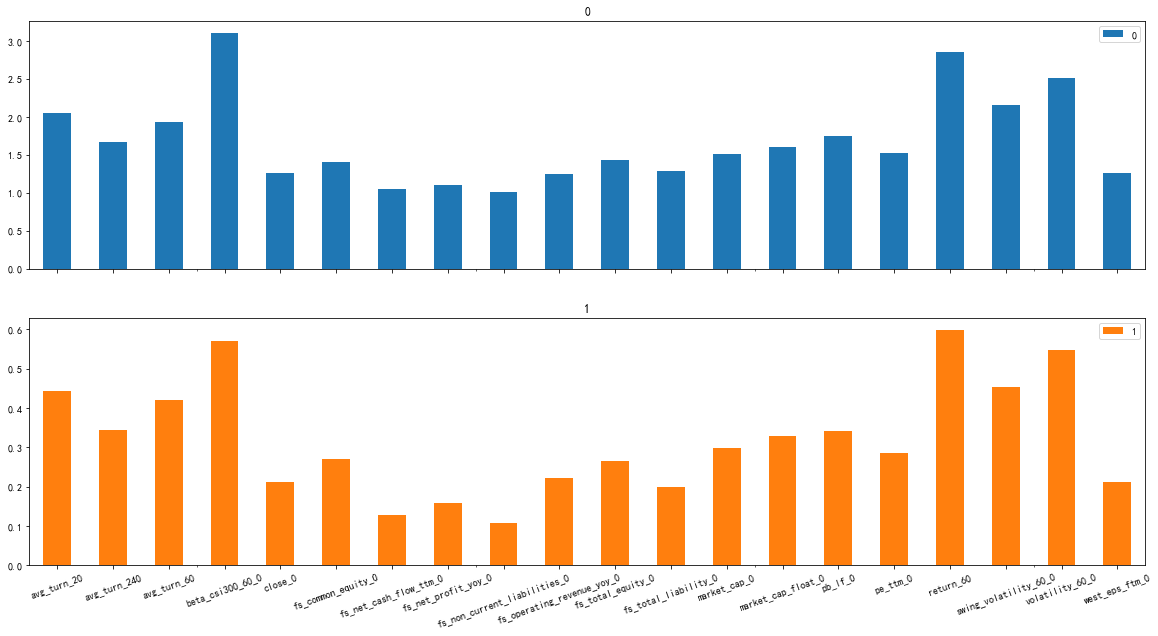

In [37]:
def _f(x:pd.Series):
    return pd.Series([x.mean(),x[x>2].count()/x.count(),])
    pass
z.abs().apply(_f).T.plot.bar(figsize=(20,10),subplots=True)
plt.xticks(rotation=20)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

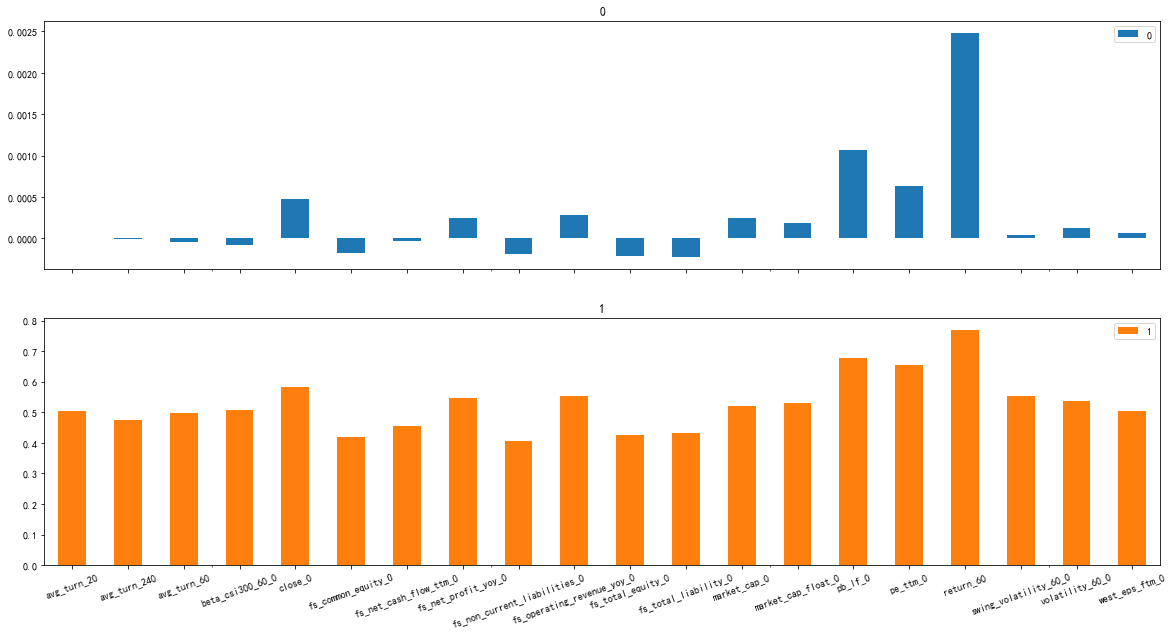

In [38]:
def _f(x:pd.Series):
    return pd.Series([x.mean(),x[x>0].count()/x.count(),])
    pass
y.apply(_f).T.plot.bar(figsize=(20,10),subplots=True)
plt.xticks(rotation=20)

#### 因子IC值辅助检验
1. 因子𝑘的IC值，一般是指个股第𝑇期在因子𝑘上的暴露度与𝑇+1期的收益率的相关系数；
2. 因子 IC 值反映的是个股下期收益率和本期因子暴露度的线性相关程度，反应该因子进行收益率预测的稳健性；
3. 回归法中计算出的因子收益率本质上是一个斜率，反映的是从该因子可能获得的收益的大小，这并不能代表任何关于稳健性的信息；
4. 在利用 IC 值评价因子有效性时，可以预先对因子进行提纯，排除行业、市值等重要因素的
影响，使结果更明晰。具体来说，就是在因子标准化处理之后，在每个截面期上用其做因变
量对市值因子及行业因子等做线性回归，取残差作为因子值的一个替代，这种做法可以消除
因子在行业、板块、市值等方面的偏离。

In [39]:
%%time
# 求残差序列
def _f0(y:pd.Series,x:pd.DataFrame)->pd.Series:
    return y-stm.OLS(endog=y,exog =x,).fit().predict(x)
def _f1(x:pd.DataFrame)->pd.DataFrame:
    _x=x.loc[:,b.columns.to_list()+['market_cap_0']]
    return pd.DataFrame(
        data={i:_f0(y=x.loc[:,i],x=_x) for i in c.columns}
    )
def _f2(x:pd.DataFrame)->pd.Series:
    return x.loc[:,c.columns].corrwith(x.loc[:,a.columns[-1]])
    pass
y=x.groupby('date').apply(_f1).merge(#.loc[('2019-06-04',slice(None)),:]
    right=a.groupby('instrument').apply(lambda i:i.shift(-1)),
    right_index=True,left_index=True,how='inner'
).sort_index(axis=0,level=0).groupby('date').apply(_f2)

Wall time: 16.5 s


5. 当得到各因子 IC 值序列后，我们可以仿照上一小节𝑡检验的分析方法进行计算：
    1. IC 值序列的均值及绝对值均值：判断因子有效性；
    2. IC 值序列的标准差：判断因子稳定性；
    3. IC 值序列大于零（或小于零）的占比：判断因子效果的一致性。


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

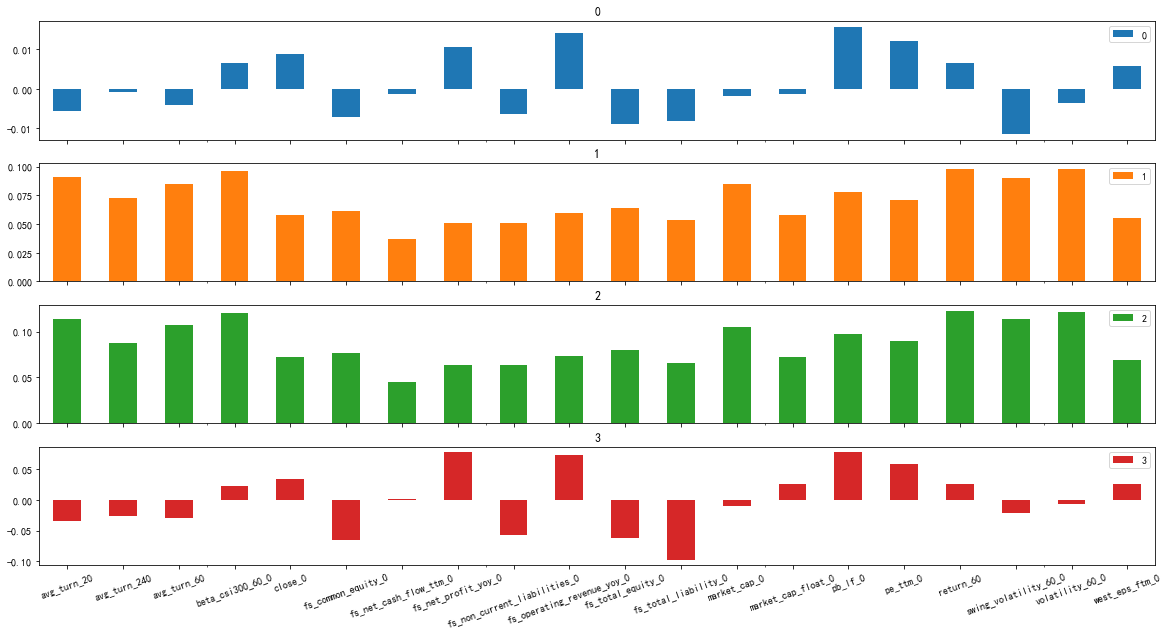

In [40]:
def _f(x:pd.Series)->pd.Series:
    return pd.Series([
        x.mean(),x.abs().mean(),x.std(ddof=0),x[x>0].count()/x.count()-.5,
    ])
    pass
y.apply(_f).T.plot.bar(figsize=(20,10),subplots=True)
plt.xticks(rotation=20)

#### 因子打分法回测辅助鉴别
详见《alphalens》

## 收益模型

### 资产收益模型

$\begin{bmatrix}\tilde{r_1}\\\vdots\\\tilde{r_n}\end{bmatrix}=\begin{bmatrix}X_{11}&\dots&X_{1k}\\\vdots&\ddots&\vdots\\X_{n1}&\dots&X_{nk}\end{bmatrix}\begin{bmatrix}\tilde{f_1}\\\vdots\\\tilde{f_k}\end{bmatrix}+\begin{bmatrix}\tilde{\mu_1}\\\vdots\\\tilde{\mu_n}\end{bmatrix}$
1. $\tilde{r}$：标的预期收益
2. $X$：标的因子暴漏
3. $\tilde{f}$：因子预期收益
4. $\tilde{\mu}$：残差收益

### 大类因子分析
在有效因子筛选出来之后，我们首先需要根据大类对因子的相关性进行𝑡检验，对于相
关性较高的因子，要么舍弃显著性较低的因子，要么进行因子合成。

#### 同类型因子的相关性检验
1. 相关系数绝对值的均值
2. 相关系数绝对值的中位数
3. t检验:

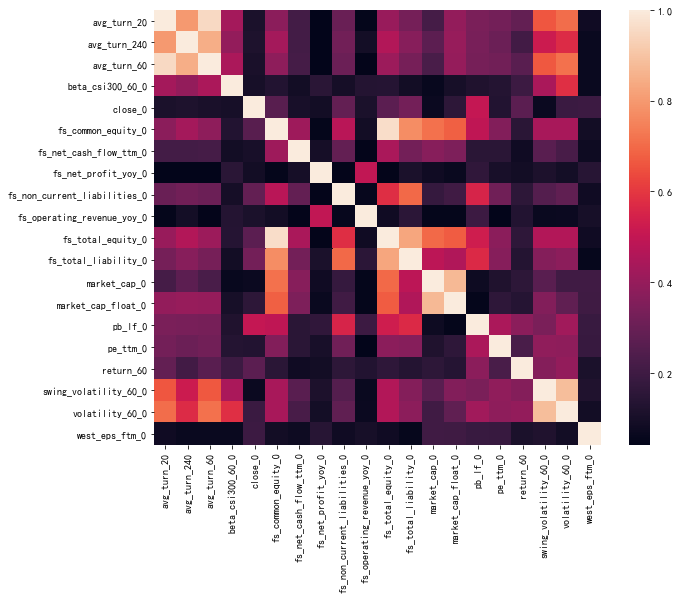

In [41]:
plt.figure(figsize=(10,8))
sns.heatmap(
    data=(c
          .groupby('date').apply(lambda i:i.corr())
          .groupby(level=1)
          .apply(lambda i:
                 i.abs().mean()# 相关系数绝对值的均值
#                  i.abs().median()#相关系数绝对值的中位数
#                  i.abs().mean()/i.abs().std(ddof=1)*((i.count()-1)**(1/2))
                )
    )
)

In [42]:
(c
          .groupby('date').apply(lambda i:i.corr())
          .groupby(level=1)
          .apply(lambda i:
#                  i.abs().mean()# 相关系数绝对值的均值
#                  i.abs().median()#相关系数绝对值的中位数
                 i.abs().mean()/i.abs().std(ddof=1)*((i.count()-1)**(1/2))
                ).round(0)
    )

,avg_turn_20,avg_turn_240,avg_turn_60,beta_csi300_60_0,close_0,fs_common_equity_0,fs_net_cash_flow_ttm_0,fs_net_profit_yoy_0,fs_non_current_liabilities_0,fs_operating_revenue_yoy_0,fs_total_equity_0,fs_total_liability_0,market_cap_0,market_cap_float_0,pb_lf_0,pe_ttm_0,return_60,swing_volatility_60_0,volatility_60_0,west_eps_ftm_0
avg_turn_20,inf,440.0,1247.0,146.0,29.0,139.0,181.0,27.0,154.0,31.0,188.0,145.0,62.0,115.0,59.0,65.0,31.0,280.0,406.0,21.0
avg_turn_240,440.0,inf,826.0,87.0,77.0,681.0,200.0,17.0,328.0,28.0,575.0,211.0,75.0,150.0,198.0,70.0,30.0,159.0,210.0,25.0
avg_turn_60,1247.0,826.0,inf,148.0,29.0,166.0,280.0,31.0,172.0,31.0,224.0,189.0,60.0,116.0,58.0,69.0,31.0,455.0,527.0,21.0
beta_csi300_60_0,146.0,87.0,148.0,inf,25.0,28.0,28.0,33.0,20.0,36.0,30.0,21.0,26.0,41.0,25.0,34.0,25.0,78.0,99.0,23.0
close_0,29.0,77.0,29.0,25.0,inf,425.0,91.0,29.0,314.0,27.0,415.0,436.0,27.0,78.0,221.0,27.0,57.0,21.0,43.0,23.0
fs_common_equity_0,139.0,681.0,166.0,28.0,425.0,inf,95.0,68.0,249.0,22.0,1002.0,430.0,382.0,539.0,475.0,105.0,26.0,104.0,138.0,22.0
fs_net_cash_flow_ttm_0,181.0,200.0,280.0,28.0,91.0,95.0,inf,42.0,104.0,19.0,108.0,53.0,190.0,201.0,76.0,44.0,27.0,158.0,158.0,22.0
fs_net_profit_yoy_0,27.0,17.0,31.0,33.0,29.0,68.0,42.0,inf,73.0,144.0,72.0,69.0,17.0,18.0,63.0,32.0,27.0,22.0,17.0,21.0
fs_non_current_liabilities_0,154.0,328.0,172.0,20.0,314.0,249.0,104.0,73.0,inf,62.0,471.0,760.0,66.0,93.0,422.0,135.0,33.0,67.0,93.0,24.0
fs_operating_revenue_yoy_0,31.0,28.0,31.0,36.0,27.0,22.0,19.0,144.0,62.0,inf,20.0,189.0,18.0,22.0,46.0,23.0,38.0,19.0,32.0,22.0


#### 因子取舍或者因子合成
1. 根据因子本身的有效性进行排序，挑选最有效的因子进行保留，删除其他因子
2. 对因子集合进行合成，尽可能多的保留有效因子信息；

In [43]:
x.columns

Index(['s_dq_adjclose', '交通运输', '休闲服务', '传媒', '公用事业', '农林牧渔', '化工', '医药生物',
       '商业贸易', '国防军工', '家用电器', '建筑材料', '建筑装饰', '房地产', '有色金属', '机械设备', '汽车',
       '电子', '电气设备', '纺织服装', '综合', '计算机', '轻工制造', '通信', '采掘', '钢铁', '银行',
       '非银金融', '食品饮料', 'avg_turn_20', 'avg_turn_240', 'avg_turn_60',
       'beta_csi300_60_0', 'close_0', 'fs_common_equity_0',
       'fs_net_cash_flow_ttm_0', 'fs_net_profit_yoy_0',
       'fs_non_current_liabilities_0', 'fs_operating_revenue_yoy_0',
       'fs_total_equity_0', 'fs_total_liability_0', 'market_cap_0',
       'market_cap_float_0', 'pb_lf_0', 'pe_ttm_0', 'return_60',
       'swing_volatility_60_0', 'volatility_60_0', 'west_eps_ftm_0'],
      dtype='object')

In [44]:
y=['avg_turn_20', 'avg_turn_240', 'avg_turn_60',]

##### 等权法

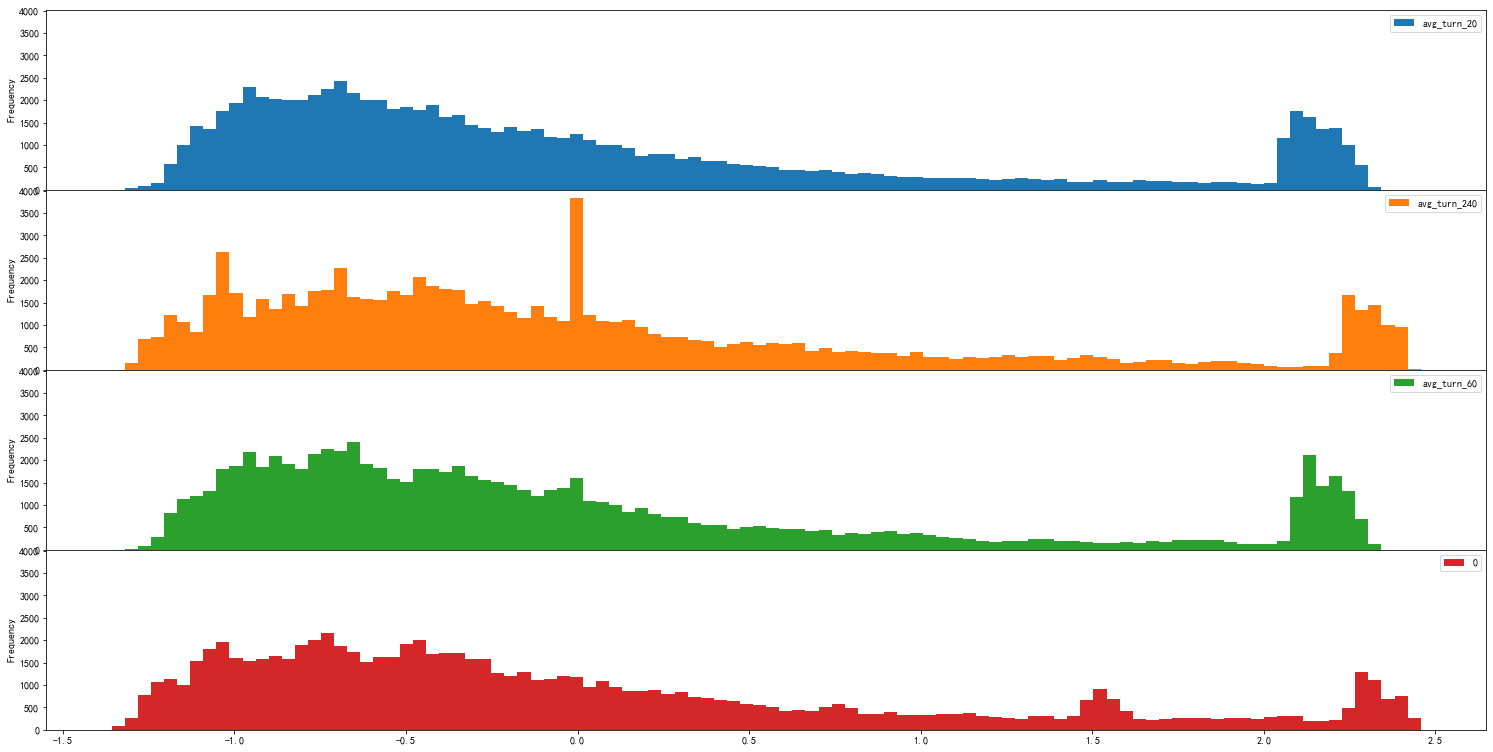

In [45]:
pd.concat(objs=(
    x.loc[:,y],
    f_z_score((x['avg_turn_20']+x['avg_turn_60']+x['avg_turn_240'])/3),)
          ,axis=1,).plot.hist(figsize=(20,10),bins=100,subplots=True,sharex=True,sharey=True,layout=(4,1))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

##### 历史收益率加权法

In [46]:
%%time
def _f(x:pd.DataFrame)->pd.DataFrame:
    y=pd.concat(
        objs=[
            stm.OLS(
                endog=x.loc[:,a.columns],
                exog =x.loc[:,b.columns.to_list()+[i]] 
            ).fit().params[-1:]
            for i in c.columns
        ]
    )
    return y
z=x.groupby('date').apply(_f)# .loc[('2019-03-04',slice(None)),:]

d:\pp\miniconda3\envs\pyqi\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


Wall time: 20.5 s


In [47]:
z.mean().loc[y].abs()/z.mean().loc[y].abs().sum()

avg_turn_20     0.049878
avg_turn_240    0.075297
avg_turn_60     0.874826
dtype: float64

##### 历史信息比例加权法

In [48]:
%%time
# 求残差序列
def _f0(y:pd.Series,x:pd.DataFrame)->pd.Series:
    return y-stm.OLS(endog=y,exog =x,).fit().predict(x)
def _f1(x:pd.DataFrame)->pd.DataFrame:
    _x=x.loc[:,b.columns.to_list()+['market_cap_0']]
    return pd.DataFrame(
        data={i:_f0(y=x.loc[:,i],x=_x) for i in c.columns}
    )
def _f2(x:pd.DataFrame)->pd.Series:
    return x.loc[:,c.columns].corrwith(x.loc[:,a.columns[-1]])
    pass
z=x.groupby('date').apply(_f1).merge(#.loc[('2019-06-04',slice(None)),:]
    right=a.groupby('instrument').apply(lambda i:i.shift(-1)),
    right_index=True,left_index=True,how='inner'
).sort_index(axis=0,level=0).groupby('date').apply(_f2)

Wall time: 17.7 s


In [49]:
z=np.abs((np.linalg.inv(z.loc[:,y].cov())@z.loc[:,y].mean().values))
z=z/z.sum()

In [50]:
z

array([0.50163951, 0.29389813, 0.20446237])

##### 主成分分析

In [51]:
pca=sdc.PCA(n_components=1)
pca.fit(x.loc[:,y])

PCA(n_components=1)

In [52]:
pca.explained_variance_ratio_,pca.explained_variance_

(array([0.91243615]), array([2.70360408]))

In [53]:
z=pca.transform((x.loc[:,y]))

In [54]:
z

array([[-0.92241302],
       [-1.05437087],
       [ 3.97803789],
       ...,
       [-1.39806967],
       [ 3.3389582 ],
       [ 0.2298251 ]])

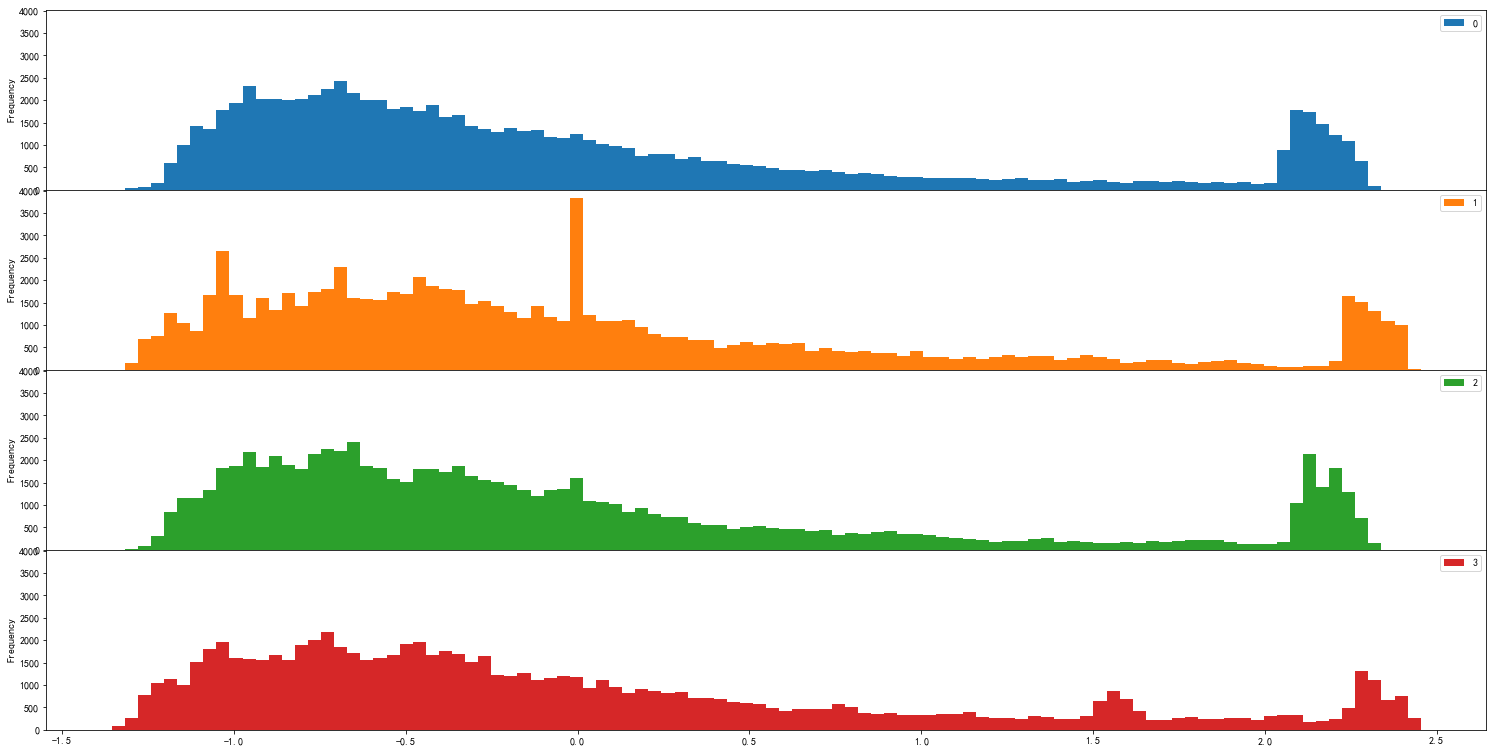

In [55]:
pd.DataFrame(np.c_[
    x.loc[:,y].values,
    f_z_score(pd.Series(z.reshape(-1))).values,
]).plot.hist(figsize=(20,10),bins=100,subplots=True,sharex=True,sharey=True,layout=(4,1))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

### 因子共线性分析

因子共线性分析和大类因子分析的本质目标都是一致的，都是避免最终的回归过程中出现多
重共线性问题。分作两个环节进行的理由是：如果是经济含义类似的同类型因子，存在明显
相关性，为尽可能多的保留因子信息，我们可以将因子进行合并；如果是经济含义不同的因
子，存在明显相关性，我们只能有所取舍，保留更加显著的因子，而舍弃相对不显著的因子，
因为多因子模型除了效果，最终还是要讲求因子本身的经济含义的。

### 残差异方差分析

异方差性（Heteroscedasticity）是相对于同方差而言的。所谓同方差，是为了保证回归参数
估计量具有良好的统计性质，经典线性回归模型的一个重要假定：总体回归函数中的随机误
差项满足同方差性，即它们都有相同的方差。如果这一假定不满足，即：随机误差项具有不
同的方差，则称线性回归模型存在异方差性。
对于回归模型：

$\tilde{r_j}=\sum_{k=1}^{K}{(x_{jk}\tilde{f_{k}})}+\tilde{\mu_{j}}$

1. 如果残差项的条件方差相同，即$Var(\tilde{\mu_j}|x_{j1},\dots,x_{jk})=\sigma^2$,则称为同方差性；
1. 如果残差项的条件方差不同，即$Var(\tilde{\mu_j}|x_{j1},\dots,x_{jk})=\sigma_j^2$,则称为异方差性；


对于模型是否存在异方差的检验，可以采用 Breusch-Pagan test（布伦斯-帕甘检验） 或者 White test（怀特检验） 两种方法。

对于存在异方差的模型，在进行回归的时候需要采用加权最小二乘法（Weighted Least
Square，WLS）。

### 多元线性回归

因子集的转换步骤：
1. 因子集𝐹1：最原始的因子集；
2. 因子集𝐹2：对𝐹1有效因子筛选后的因子集；
3. 因子集𝐹3：对𝐹2大类因子分析，经过因子取舍或者因子合成之后的因子集；
4. 因子集𝐹4：对𝐹3进行多重共线性分析，取舍之后的因子集。
5. 因子集𝐹5：对𝐹4做残差的异方差分析处理，获得最终因子集。

多因子回归模型：
>$\large\tilde{r_j^t}=\sum_{s=1}^S{X_{js}^t\tilde{f_s^t}}+\sum_{k=1}^K{X_{jk}^t\tilde{f_k^t}}+\tilde{u_j^t}\\
\tilde{r_j^t}:股票𝑗在第𝑡期的收益率\\
X_{js}^t:股票𝑗在第𝑡期在行业𝑠上的暴露\\
\tilde{f_s^t}:行业𝑠在第𝑡期的收益率\\
X_{jk}^t:股票𝑗在第𝑡期在因子𝑘上的暴露\\
\tilde{f_k^t}:因子𝑘在第𝑡期的收益率
$

经典回归模型的基本假设：
1. 参数的线性性：回归模型对于参数而言是线性的；
2. 样本的随机性：样本是从总体中随机抽样得到的；
3. 不存在完全共线性：每个解释变量具有一定变异并且自变量之间不存在完全的线性相
关关系；
4. 零条件均值：$𝐸(𝑢_𝑗|x_{1𝑗},\dots,x_{Kj}) = 0$;
5. 同方差性：$𝑉ar(𝑢_𝑗|x_{1j},\dots,x_{Kj}) = \sigma^2$;
6. 正态性：$𝑢_𝑗$独立于所有变量，并且$𝑢_𝑗~𝑁(0, 𝜎^2)$;

所以前面的大类因子分析，因子共线性分析，残差异方差分析，本质都是让因子能够满足经
典回归模型的基本假设。


### 二级因子合成

In [56]:
fac_f

{'market_cap_0': '总市值',
 'market_cap_float_0': '流通市值',
 'close_0': '收盘价',
 'pb_lf_0': '市净率(LF)',
 'pe_ttm_0': '市盈率(TTM)',
 'fs_net_cash_flow_ttm_0': '经营活动现金净流量(TTM)',
 'fs_net_profit_yoy_0': '归属母公司股东的净利润同比增长率',
 'fs_operating_revenue_yoy_0': '营业收入同比增长率',
 'fs_non_current_liabilities_0': '非流动负债',
 'fs_common_equity_0': '普通股权益总额',
 'fs_total_liability_0': '负债合计',
 'fs_total_equity_0': '所有者权益合计',
 'avg_turn_20': '过去i个交易日的平均换手率',
 'avg_turn_60': '过去i个交易日的平均换手率',
 'avg_turn_240': '过去i个交易日的平均换手率',
 'beta_csi300_60_0': 'BETA值(沪深300)',
 'return_60': '过去i个交易日的收益',
 'volatility_60_0': '波动率',
 'swing_volatility_60_0': '振幅波动率',
 'west_eps_ftm_0': '一致预测每股收益（未来12个月）'}

In [57]:
f2=namedtuple('F2',field_names=fac_f.keys())(*fac_f.keys())

_f1=['lncap','beta','rstr','dastd','cmra','hsigma','nlsize','btop','stom','stoq','stoa','epfwd','cetop','etop','egrlf','egrsf','egro','sgro','mlev','blev','dtoa']
F1=namedtuple(typename='F1',field_names=_f1)
f1=F1(*_f1)

_f0=['size','beta','momentum','volatility','midcapitalization','booktoprice','liquidity','earning','growth','leverage']
F0=namedtuple(typename='F0',field_names=_f0)
f0=F0(*_f0)

In [58]:
%%time
# 因子,对于单个标的ffill填充
c=(
    h5['fac']
    .set_index(['date','instrument'])
    .groupby('instrument')
    .apply(lambda i:i.fillna(method='ffill'))
#     .groupby('date')
#     .apply(lambda i:i.apply(lambda j:f_z_score(f_mad(j)),axis=0))
)

Wall time: 723 ms


In [59]:
x=pd.concat(objs=(a,b,c),join='inner',axis=1).sort_index(axis=0,level=0)
x.shape

(83761, 49)

#### SIZE（市值因子）
size=lncap*1.0

lncap:公司股票总市值的自然对数，最常见的风格因子

In [60]:
x[f1.lncap]=np.log(x[f2.market_cap_0])

#### BETA（贝塔因子）
beta:股票超额收益日序列和市值加权指数超额收益日序列的回归系数，表示股票相对于指数涨跌的弹性大小

In [61]:
x[f1.beta]=x[f2.beta_csi300_60_0]

#### MOMENTUM（动量因子）

In [62]:
x[f1.rstr]=x[f2.return_60]

#### VOLATILITY（波动因子）

In [63]:
x[f1.dastd]=x[f2.volatility_60_0]
x[f1.cmra]=x[f2.swing_volatility_60_0]
x[f1.hsigma]=0 # 就是计算beta收益之时的残差收益率的波动率，表示股票不能被beta所解释部分收益的波动率

#### MIDCAPITALIZATION

In [64]:
x[f1.nlsize]=x[f2.market_cap_float_0]**3

#### BOOK-TO-PRICE（账面市值比因子）
btop是上个季报公司普通股权账面价值（就是净资产）除以公司当前的市值

In [65]:
x[f1.btop]=1/x[f2.pb_lf_0]

#### LIQUIDITY（流动性因子）

In [66]:
x[f1.stom]=x[f2.avg_turn_20]
x[f1.stoq]=x[f2.avg_turn_60]
x[f1.stoa]=x[f2.avg_turn_240]

####  EARNING（盈利预期因子）
盈利预期因子的核心是EP因子，包含预期盈利、现金流量、过去盈利三方面
1. epfwd(predicted earnings to price ratio):是预期盈利市值比，预期盈利采用的是分析师对未来12个月预期盈利加权平均值
1. cetop(cash earnings to price ratio ):是现金流量市值比，现金流量是过去12月的历史数据值
1. etop (trailing earnings to price ratio ):是盈利市值比，盈利是过去12月的历史数据（就是pe_ttm的倒数值）

In [67]:
x[f1.epfwd]=x[f2.west_eps_ftm_0]/x[f2.close_0]
x[f1.cetop]=x[f2.fs_net_cash_flow_ttm_0]/x[f2.market_cap_0]
x[f1.etop]=1/x[f2.pe_ttm_0]

#### GROWTH（成长因子）
1. egrlf(long term predicted earnings growth):是未来3-5年分析师预期盈利增长率
1. egrsf(short term predicted earnings growth):是未来1年分析师预期盈利增长率
1. egro(earnings growth trailing five years):是过去5年盈利增长率
1. sgro(sales growth trailing five years ):是过去5年营业收入增长率

In [68]:
x[f1.egrlf]=0
x[f1.egrsf]=0
x[f1.egro]=x[f2.fs_net_profit_yoy_0]
x[f1.sgro]=x[f2.fs_operating_revenue_yoy_0]

#### LEVERAGE（杠杆因子）
1. mlev:$市场杠杆=\frac{普通股市值+优先股账面价值+长期负债账面价值}{普通股市值}$
2. dtoa:$资产负债比=\frac{总负债账面价值}{总资产账面价值}$
3. blev:$账面杠杆=\frac{普通股账面价值+优先股账面价值+长期负债账面价值}{普通股账面价值}$

In [69]:
x[f1.mlev]=(x[f2.market_cap_0]+x[f2.fs_non_current_liabilities_0])/x[f2.market_cap_0]
x[f1.dtoa]=x[f2.fs_total_liability_0]/(x[f2.fs_total_liability_0]+x[f2.fs_total_equity_0])
x[f1.blev]=(x[f2.fs_common_equity_0]+x[f2.fs_non_current_liabilities_0])/x[f2.fs_common_equity_0]

### 二级因子标准化

In [70]:
%%time
# 二级因子标准化
x.loc[:,list(f1)]=(
    x.loc[:,list(f1)]
    .groupby('date')
    .apply(lambda i:i.apply(lambda j:f_z_score(f_mad(j)),axis=0))
)

Wall time: 26.7 s


In [71]:
len(list(f1))

21

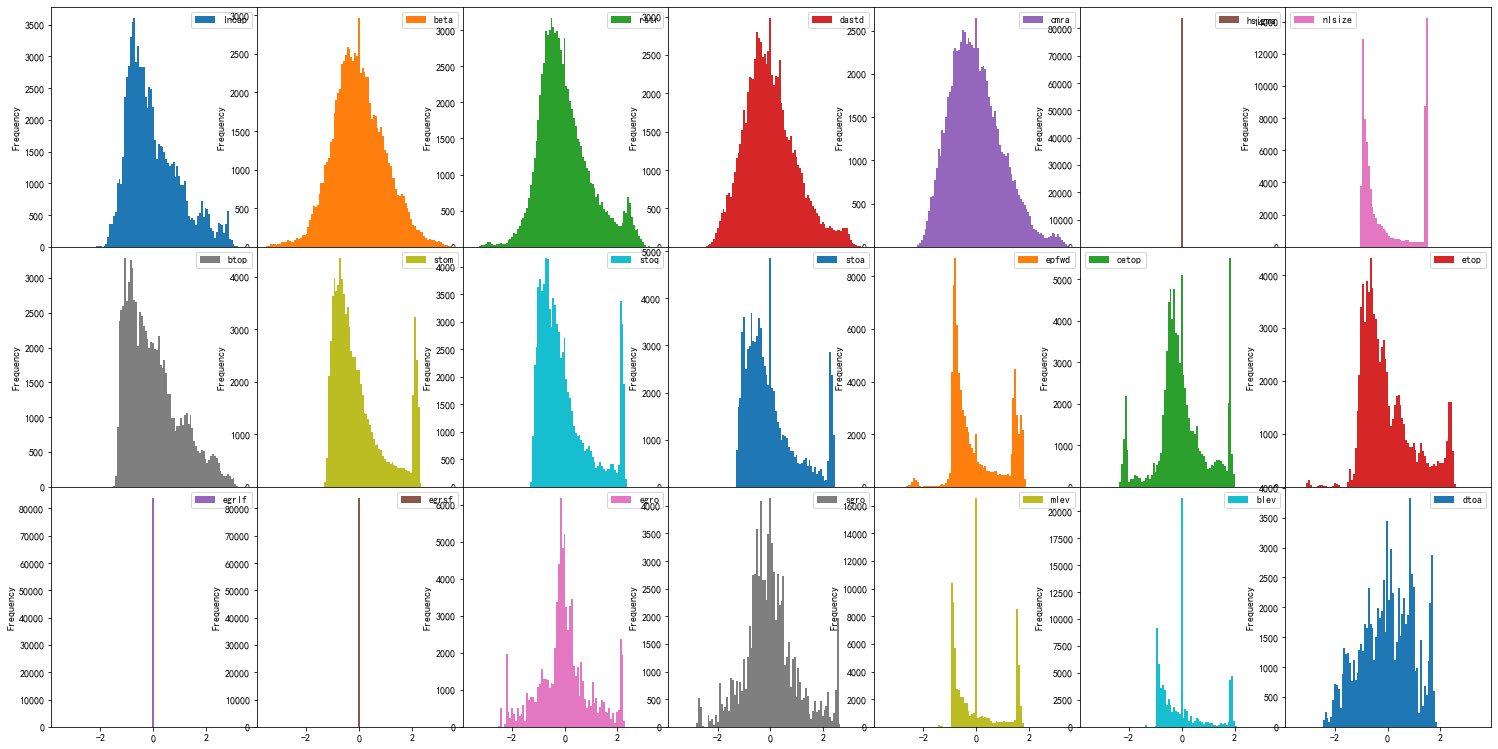

In [72]:
x.loc[:,list(f1)].plot.hist(figsize=(20,10),bins=100,subplots=True,sharex=True,sharey=False,layout=(3,7))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

### 一级因子合成

In [73]:
list(f0)

['size',
 'beta',
 'momentum',
 'volatility',
 'midcapitalization',
 'booktoprice',
 'liquidity',
 'earning',
 'growth',
 'leverage']

In [74]:
x[f0.size]=x[f1.lncap]
x[f0.beta]=x[f1.beta]
x[f0.momentum]=x[f1.rstr]
x[f0.volatility]=x.loc[:,[f1.dastd,f1.cmra,f1.hsigma]].mean(axis=1)
x[f0.midcapitalization]=x[f1.nlsize]
x[f0.booktoprice]=x[f1.btop]
x[f0.liquidity]=x.loc[:,[f1.stom,f1.stoq,f1.stoa]].mean(axis=1)
x[f0.earning]=x.loc[:,[f1.epfwd,f1.cetop,f1.etop]].mean(axis=1)
x[f0.growth]=x.loc[:,[f1.egrlf,f1.egrsf,f1.egro,f1.sgro]].mean(axis=1)
x[f0.leverage]=x.loc[:,[f1.mlev,f1.blev,f1.dtoa]].mean(axis=1)

### 一级因子标准化

In [75]:
%%time
# 二级因子标准化
x.loc[:,list(f0)]=(
    x.loc[:,list(f0)]
    .groupby('date')
    .apply(lambda i:i.apply(lambda j:f_z_score(f_mad(j)),axis=0))
)

Wall time: 12.5 s


In [76]:
len(list(f0))

10

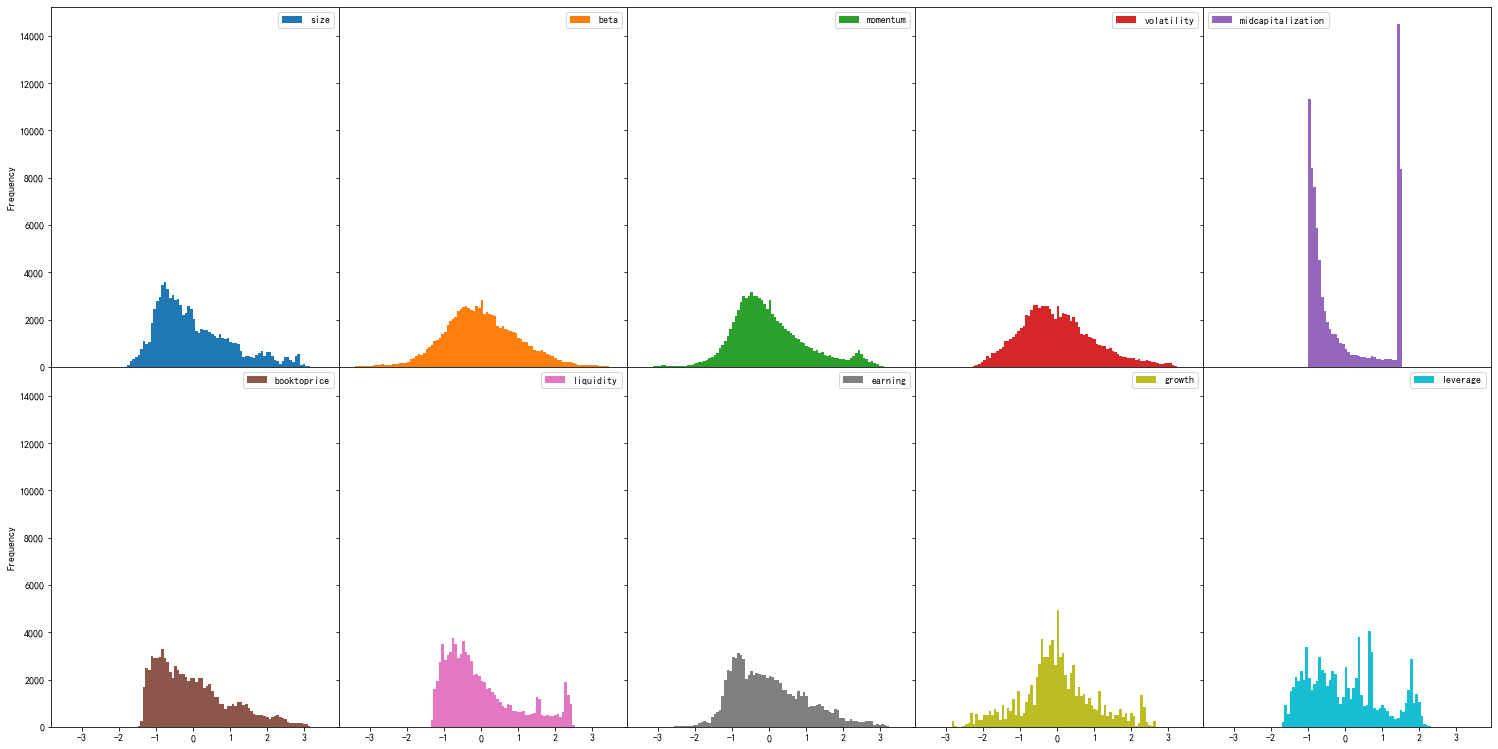

In [77]:
x.loc[:,list(f0)].plot.hist(figsize=(20,10),bins=100,subplots=True,sharex=True,sharey=True,layout=(2,5))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

### 估计因子收益率

#### 因子历史收益率序列

$F=\begin{bmatrix}\tilde{f_1^1}&\dots&\tilde{f_K^1}\\\vdots&\ddots&\vdots\\\tilde{f_1^T}&\dots&\tilde{f_K^T}\end{bmatrix}$

In [78]:
%%time
def _f(x:pd.DataFrame)->pd.DataFrame:
    y=stm.OLS(
        endog=x.loc[:,a.columns],
        exog =x.loc[:,b.columns.to_list()+list(f0)] 
    ).fit().params[:]
    return y
y=x.groupby('date').apply(_f)# .loc[('2019-03-04',slice(None)),:]

d:\pp\miniconda3\envs\pyqi\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


Wall time: 1.89 s


In [79]:
y.head()

,交通运输,休闲服务,传媒,公用事业,农林牧渔,化工,医药生物,商业贸易,国防军工,家用电器,...,size,beta,momentum,volatility,midcapitalization,booktoprice,liquidity,earning,growth,leverage
date,,,,,,,,,,,,,,,,,,,,,
2019-03-04,0.015088,0.007486,0.006056,0.034413,0.048902,0.008252,0.019367,0.024997,0.017304,0.035694,...,0.003004,-0.001680,0.002310,0.005050,-0.006353,-0.000830,-0.000209,-0.000572,-0.000514,0.000684
2019-03-05,0.010198,-0.003247,0.012169,0.021546,0.010945,0.007059,0.013383,0.009905,0.014930,0.025761,...,0.001160,-0.004091,0.004689,0.007786,-0.004903,-0.000440,-0.000529,0.000094,0.000501,0.001526
2019-03-06,0.016567,0.007120,0.014300,0.020106,-0.012053,0.025514,0.009569,0.007440,0.001173,0.005364,...,0.000819,-0.002096,0.005604,0.003453,-0.005531,0.000029,0.001977,-0.001141,-0.000464,0.002807
2019-03-07,0.002670,0.017875,-0.014521,-0.005466,-0.055520,-0.006832,-0.000822,-0.000629,-0.008554,-0.016979,...,0.002569,-0.011003,0.010544,0.006672,-0.009653,0.004417,-0.002460,-0.004791,-0.000489,0.000546
2019-03-08,-0.054441,-0.057049,-0.074120,-0.054633,-0.032336,-0.055403,-0.026728,-0.041726,-0.054795,-0.037680,...,0.001531,-0.021537,0.005252,0.001801,0.003394,-0.005837,0.001046,-0.002550,0.000760,-0.002544


Wall time: 1.89 s


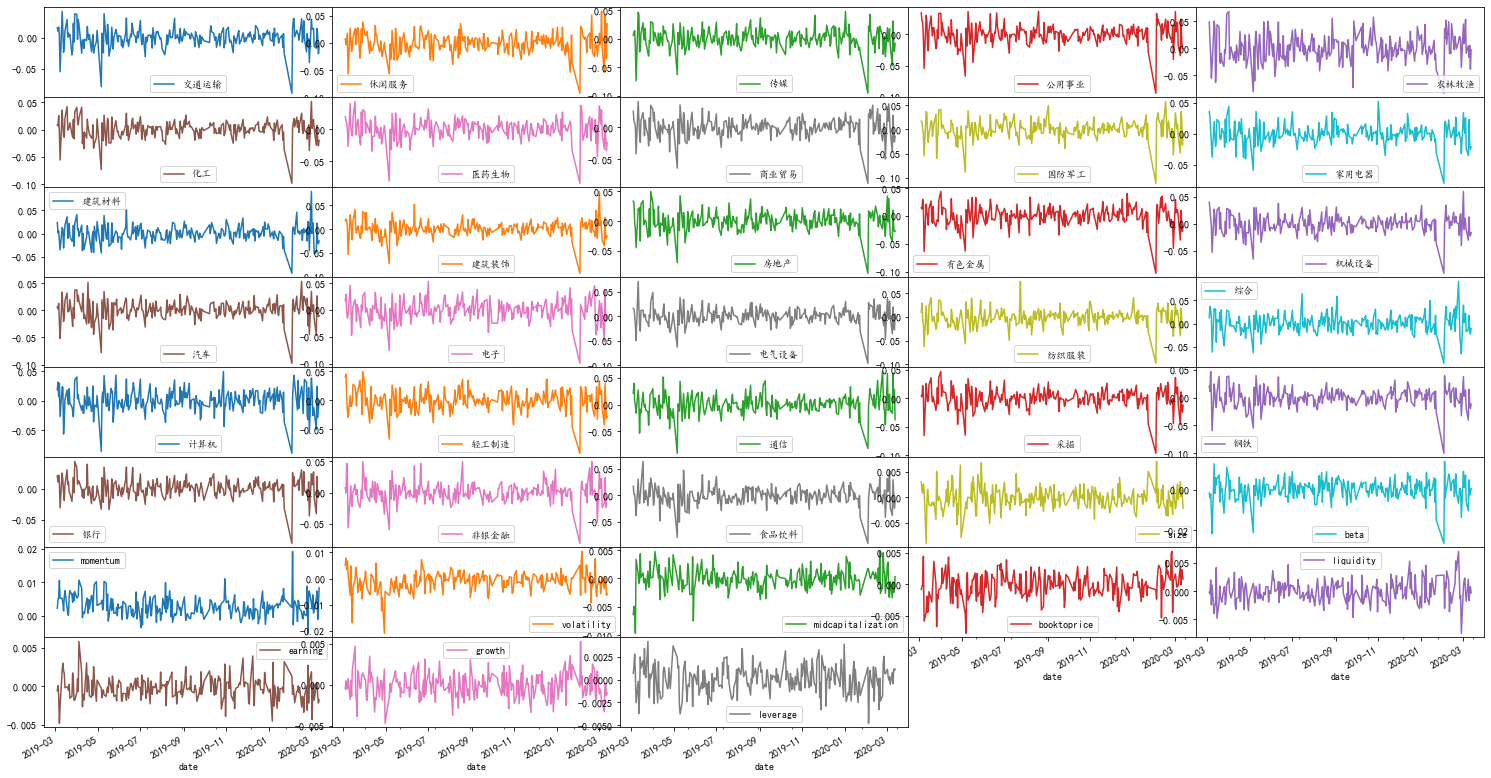

In [80]:
%%time
y.plot(figsize=(20,10),subplots=True,sharey=False,sharex=True,layout=(-1,5))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <a list of 38 Text major ticklabel objects>)

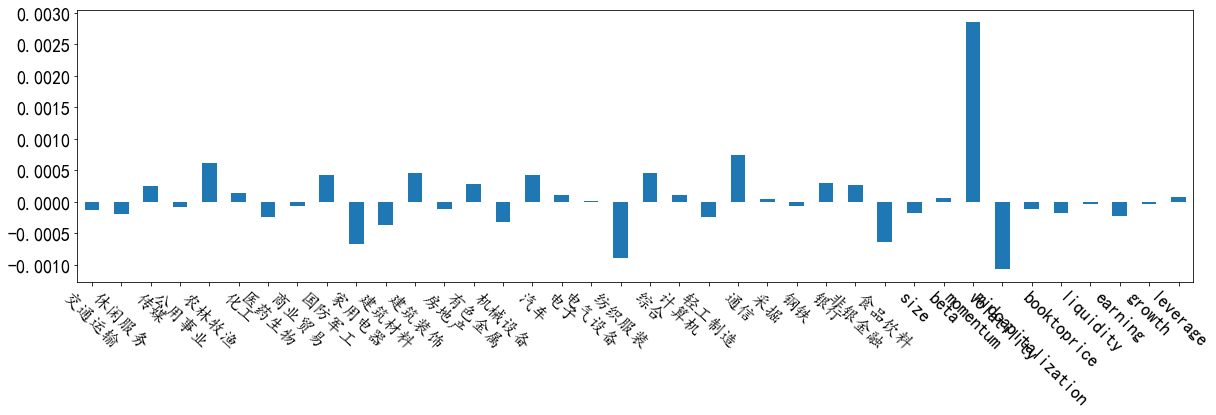

In [81]:
y.mean().plot.bar(figsize=(20,5),fontsize=18)
plt.xticks(rotation=-45)

#### 简单平均法

$\large\tilde{f_k^{T+1}}=\frac{\sum_{t=T-N+1}^{T}{\tilde{f_k^{t}}}}{N}$

In [82]:
z=y.shift(1).rolling(window=20,min_periods=0).apply(lambda i:i.mean())# 整体向前移动一步

#### 加权移动平均

In [83]:
z=y.shift(1).rolling(window=20,min_periods=1).apply(lambda i:ab.WMA(i,timeperiod=20)[-1])# 整体向前移动一步

#### 时间序列预测法

In [84]:
def tsplot(y, lags=30, figsize=(8, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('时间序列分析')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05,title='自相关系数')
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05,title='偏自相关系数')
        stm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        plt.tight_layout()
    return

##### 时序分析

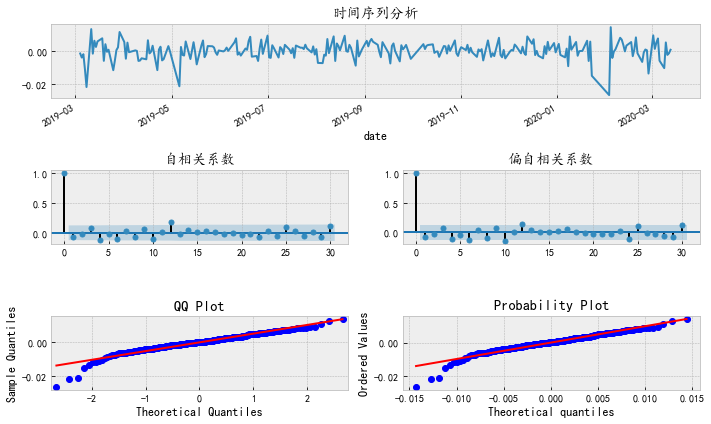

In [85]:
tsplot(y=y.loc[:,f0.beta],figsize=(10,6))

##### 参数寻优(p,q)

In [86]:
%%time
z=stm.tsa.arma_order_select_ic(y=y.loc[:,f0.beta],max_ar=3,max_ma=3,ic='aic',trend='nc',)

Wall time: 1.29 s


In [87]:
z.aic_min_order

(1, 2)

##### 模型训练

In [98]:
m=smt.ARMA(endog=y.loc[:,f0.beta],order=z.aic_min_order).fit(method='mle', trend='nc',)

d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [99]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   beta   No. Observations:                  252
Model:                     ARMA(1, 2)   Log Likelihood                 973.692
Method:                           mle   S.D. of innovations              0.005
Date:                Sun, 16 Aug 2020   AIC                          -1939.385
Time:                        10:53:50   BIC                          -1925.267
Sample:                             0   HQIC                         -1933.704
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.beta    -0.8276      0.081    -10.241      0.000      -0.986      -0.669
ma.L1.beta     0.7912      0.094      8.390      0.000       0.606       0.976
ma.L2.beta    -0.1297      0.064     -2.032      0.042      -0.255      -0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2083           +0.0000j            1.2083            0.5000
MA.1           -1.0746           +0.0000j            1.0746            0.5000
MA.2            7.1739           +0.0000j            7.1739            0.0000
-----------------------------------------------------------------------------
"""

##### 模型残差的时序分析

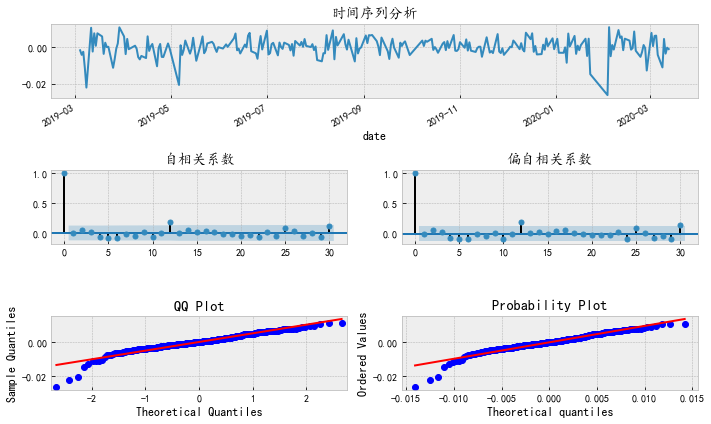

In [100]:
tsplot(y=m.resid,figsize=(10,6))

##### 历史预测

In [102]:
m.predict()#第一次运行出错，第二次不出错

date
2019-03-04    0.000000
2019-03-05    0.000096
2019-03-06    0.000390
2019-03-07    0.000347
2019-03-08    0.000642
                ...   
2020-03-09    0.000764
2020-03-10    0.000315
2020-03-11    0.001014
2020-03-12   -0.001302
2020-03-13    0.001543
Length: 252, dtype: float64

##### 未来预测

In [103]:
m.forecast(steps=10)[0]

array([-0.00120973,  0.00113226, -0.00093707,  0.00077552, -0.00064183,
        0.00053118, -0.00043961,  0.00036382, -0.0003011 ,  0.0002492 ])

In [104]:
m.predict(start=0,end=261)[-20:]

d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


242    0.001151
243    0.000420
244   -0.001395
245    0.000847
246   -0.001740
247    0.000764
248    0.000315
249    0.001014
250   -0.001302
251    0.001543
252   -0.001210
253    0.001132
254   -0.000937
255    0.000776
256   -0.000642
257    0.000531
258   -0.000440
259    0.000364
260   -0.000301
261    0.000249
dtype: float64

##### 工程组装

In [105]:
%%time
def _f(y:pd.Series)->pd.Series:
    a=stm.tsa.arma_order_select_ic(y=y.values,max_ar=3,max_ma=3,ic='aic',trend='nc',)
    b=smt.ARMA(endog=y.values,order=a.aic_min_order).fit(method='mle', trend='nc',)
    return pd.Series(b.predict(start=0,end=len(y)-1+20))
z=y.apply(_f,axis=0)

d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\pp\mini

Wall time: 1min 24s


Wall time: 1.39 s


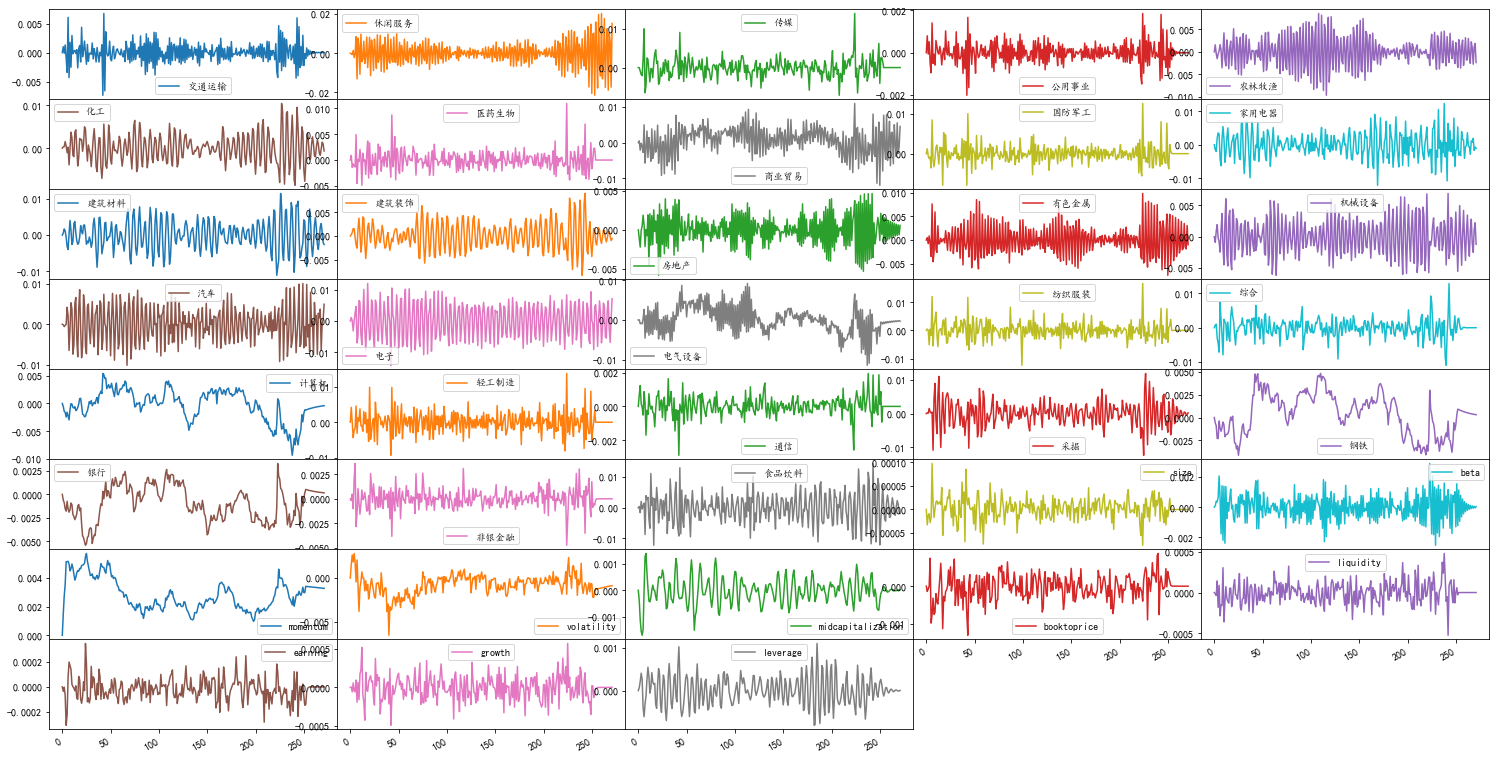

In [106]:
%%time
z.plot(figsize=(20,10),subplots=True,sharey=False,sharex=True,layout=(-1,5))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

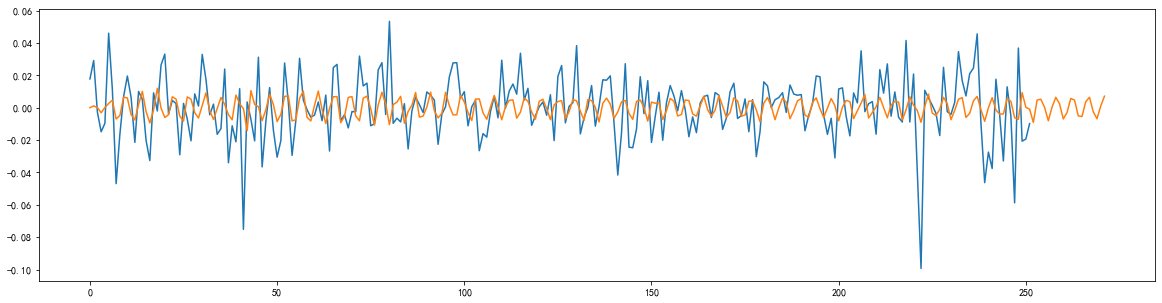

In [107]:
plt.figure(figsize=(20,5))
ax=plt.gca()
n=16
y.reset_index(drop=True)[y.columns[n]].plot(ax=ax)
z[y.columns[n]].plot(ax=ax)

#### 滤波法提取趋势项

原理：
1. 采用HP滤波法将变化不定的时间序列数据分为：周期波动数据+趋势要素数据；
2. 获得趋势要素数据之后，求差分，求平均即为预期因子收益率

公式：
>$\large minimize:f(g_t)=sum_{t=1}^T{(y_t-g_t)}^2+\lambda\sum_{t=3}^T{[g_t-g_{t-2}]}^2$

##### 案例

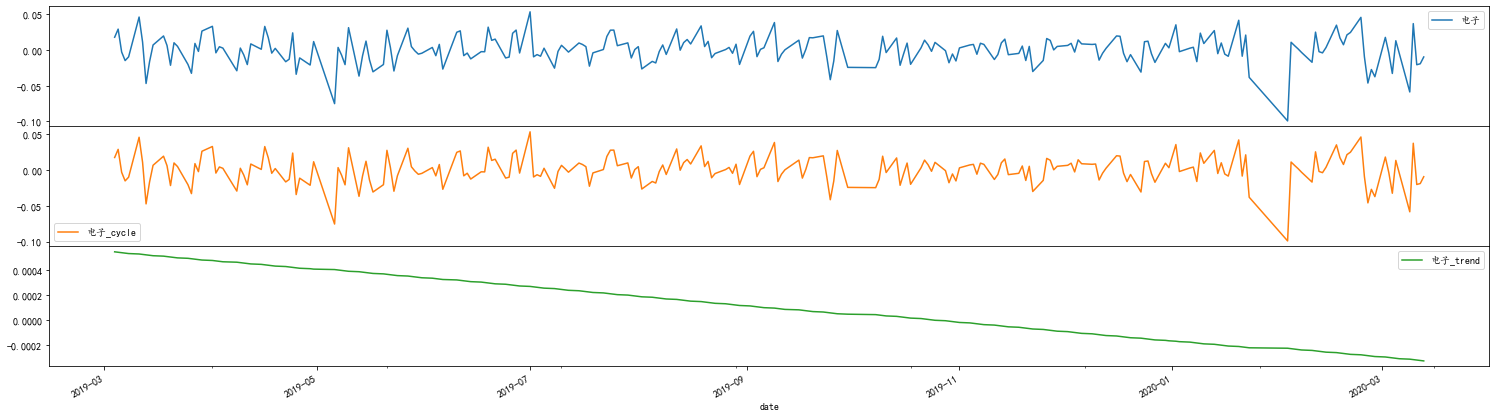

In [108]:
z=y[y.columns[16]]
pd.DataFrame(list([z]+list(stm.tsa.filters.hpfilter(x=z,lamb=1600*(60**4))))).T.plot(figsize=(20,5),subplots=True)
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

##### 工程组装

In [109]:
def _f(y:pd.Series)->pd.Series:
    return stm.tsa.filters.hpfilter(x=y,lamb=1600*(60**4))[1]
    pass
z=y.apply(_f)

Wall time: 1.49 s


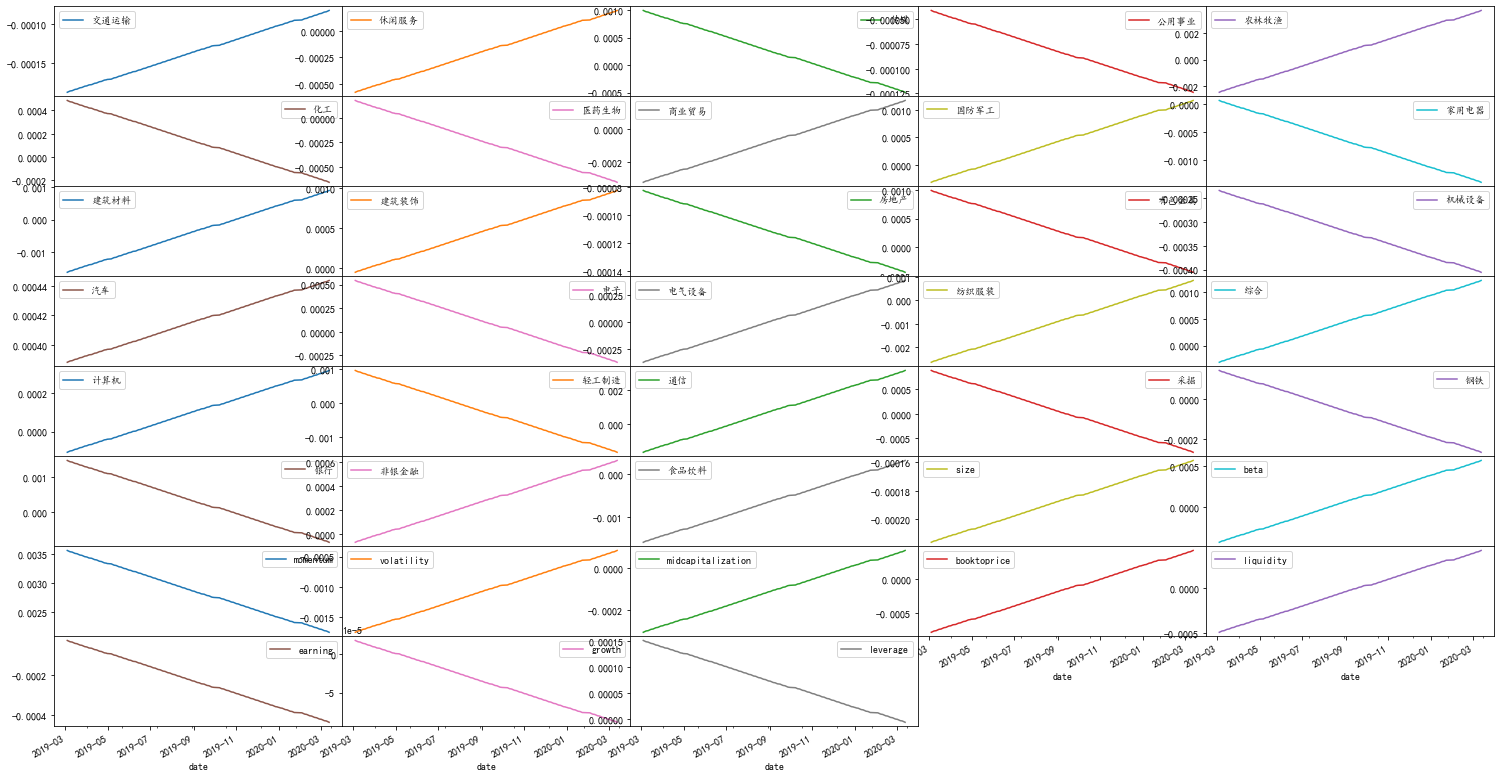

In [110]:
%%time
z.plot(figsize=(20,10),subplots=True,sharey=False,sharex=True,layout=(-1,5))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <a list of 38 Text major ticklabel objects>)

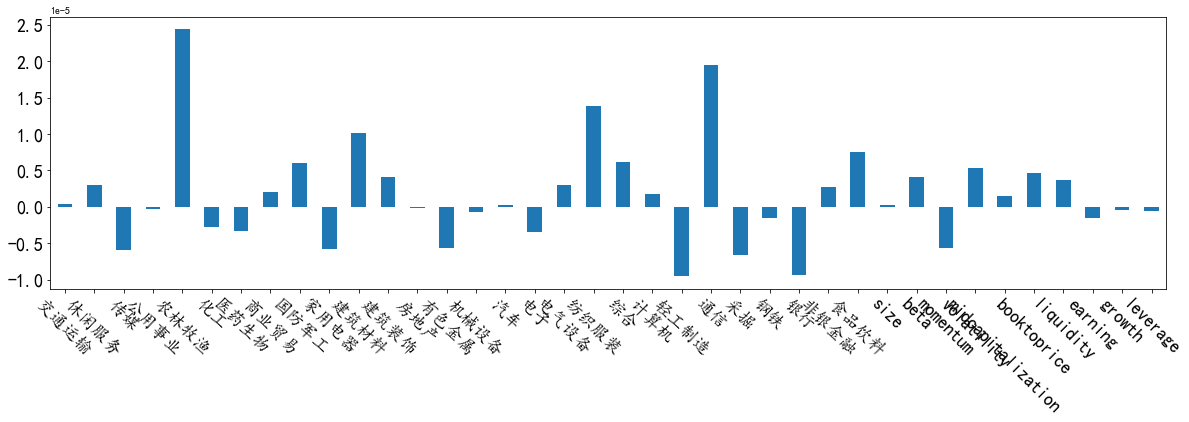

In [111]:
z.diff().mean().plot.bar(figsize=(20,5),fontsize=18)
plt.xticks(rotation=-45)

#### 计算标的资产预期收益率

公式：
>$\large r=Xf\\
\large \tilde{r_j}=\sum_{k=1}^K{X_{jk}\times \tilde{f_k}}
$

##### 估算T+1因子预期收益率

In [112]:
x1=z.diff().mean()

##### 估算T+1期因子载荷矩阵

In [113]:
x2=x.loc[:,b.columns.to_list()+list(f0)].groupby('instrument').apply(lambda i:i.iloc[-20:].mean())

##### 估算

In [114]:
x1.shape,x2.shape

((38,), (335, 38))

In [115]:
y=x2@x1

In [116]:
y

instrument
000001.SZA   -2.801215e-06
000002.SZA   -6.732537e-06
000063.SZA    1.983672e-05
000069.SZA   -9.395643e-07
000100.SZA    2.564966e-06
                  ...     
603833.SHA   -1.538898e-05
603858.SHA   -8.184967e-06
603899.SHA   -1.671688e-05
603986.SHA    4.869647e-06
603993.SHA    1.992268e-06
Length: 335, dtype: float64

## 风险模型

### 多因子模型的风险分解

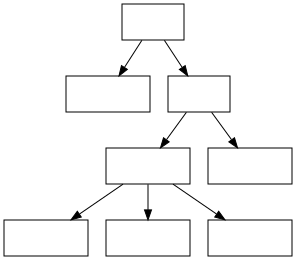

In [117]:
g=gz.Digraph()
g.attr('node', shape='box')
g.attr(rankdir='TB', )
g.edges([
    ('组合收益','业绩基准收益'),
    ('组合收益','主动收益'),
    ('主动收益','因子主动收益'),
    ('因子主动收益','市场因子收益'),
    ('因子主动收益','行业因子收益'),
    ('因子主动收益','风格因子收益'),
    ('主动收益','特定主动收益'),
])
g

### 市场风险结构

$\Large V{i,j}=\sum_{k1,k2=1}^{K}{X_{i,k1}F_{k1,k2}X_{j,k2}+\Delta_{i,j}}$
1. $V{i,j}$:股票𝑖和股票𝑗的协方差;
2. $X_{i,k1}$:股票𝑖对因子𝑘1的暴露度（因子载荷）
3. $F_{k1,k2}$:因子𝑘1和因子𝑘2 之间的收益率协方差
4. $\Delta_{i,j}$:股票𝑖和股票𝑗之间残差的协方差，𝑖 ≠ 𝑗时为 0

### 组合P
一般假设：
1. 特定收益$\mu$与因子收益$b$是不相关的，也就是说，对所有的$n$与$k$，有$Cov\{\mu_n,b_k\}=0$;
2. 如果$m\neq n$，那么股票$m$的特定收益$\mu_m$与股票$n$的特定收益$\mu_n$之间的协方差为零，也就是说，如果$m\neq n$，有$Cov\{\mu_n,\mu_m\}=0$成立。

那么：
1. 因子暴漏度：$x_p=X^Th_p$
2. $V=XFX^T+\Delta$
2. 组合𝑃的方差：$\delta_p^2=x_p^TFx_p+h_p^T\Delta h_p=h_p^TVh_p$

其中：
$F$是一个代表因子收益的$K\times K$阶协方差矩阵，$\Delta$是一个代表特定方差的$N\times N$阶对角矩阵。

### 求解各期因子收益率

In [118]:
%%time
def _f(x:pd.DataFrame)->pd.DataFrame:
    y=stm.OLS(
        endog=x.loc[:,a.columns],
        exog =x.loc[:,b.columns.to_list()+list(f0)] 
    ).fit().params[:]
    return y
y=x.groupby('date').apply(_f)# .loc[('2019-03-04',slice(None)),:]

d:\pp\miniconda3\envs\pyqi\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


Wall time: 2.08 s


### 因子收益率的协方差矩阵

In [119]:
xf=y.cov()

### 当期因子矩阵

In [120]:
# 当前t期
xt=y.index[-1]

In [121]:
# 当前t期的成分股
xc=h5['obj_weight']
xc=xc.loc[xc.date==xt,:]['instrument'].to_list()
assert len(xc)==300

In [122]:
# 当期因子矩阵
xx=x.loc[(xt,xc),b.columns.to_list()+list(f0)]

In [123]:
# 当期有因子的成分股列表
xc=[i[1] for i in xx.index]

### 当期因子收益

In [124]:
xe=y.loc[xt,:]

### 残差风险的估计

In [125]:
%%time
def _f(x:pd.DataFrame)->pd.Series:
    y=stm.OLS(
        endog=x.loc[:,a.columns],
        exog=x.loc[:,b.columns.to_list()+list(f0)],
    ).fit().resid
    return y
    pass
y=x.groupby('date').apply(_f)

Wall time: 1.96 s


In [126]:
xd=np.diag(y.unstack(2).droplevel(0)[xc].var())

In [127]:
xd.shape

(298, 298)

## 优化模型

### 二次规划

$\large\underset{H}{min}(\frac{1}{2}H^TQH+H^Tc)\\
s.t.\ \ A^TH\leq b
$

### 收益目标和风险目标

控制风险，收益最大化：
>$\underset{h_j}{max}\sum_{j=1}^N{(\tilde{r_j^{T+1}}h_j)}\\
s.t.\ \ h_p^TVh_p\leq \sigma^2\\
\sum_{j=1}^N{h_j}=1,h_j\geq 0,j=1,\dots,N$

控制收益，风险最小化：
>$\underset{h_j}{min}(h_p^TVh_p)\\
s.t.\ \ \sum_{j=1}^N{(\tilde{r_j^{T+1}}h_j)}\geq r\\
\sum_{j=1}^N{h_j}=1,h_j\geq 0,j=1,\dots,N$

### 个股上下限约束

组合P存在业绩基准B:
1. $h_{pa}=h_p-h_b$
2. $x_{pa}=X^Th_{pa}$
3. $\delta_{pa}^2=x_{pa}^TFx_{pa}+h_{pa}^T\Delta h_{pa}=h_{pa}^TVh_{pa}$

控制风险，收益最大化：
>$\underset{h_j}{max}\sum_{j=1}^N{(\tilde{r_j^{T+1}}h_{paj})}\\
s.t.\ \ h_{pa}^TVh_{pa}\leq \sigma^2\\
\sum_{j=1}^N{h_{{paj}}}=0,h_j^{upper}\geq h_{paj}\geq -h_{bj},j=1,\dots,N$

### 行业权重约束

1. 通过股指期货对冲组合的市场风险（市值对冲）
2. 通过行业中性对冲组合的行业风险（行业中性）

行业中性：对于所有股票组成的哑变量矩阵S：
>$S=\begin{bmatrix}
 S_{11}& \dots & S_{1s}\\ 
 \vdots& \ddots &\vdots \\
 S_{N1}& \dots & S_{Ns}\\ 
\end{bmatrix}
$

要求：
>$\sum_{j=1}^N{(h_{paj}s_{ji})}=0$

### 因子暴漏约束

>$|\sum_{j=1}^N{(h_{paj}x_{jk})}|\leq x_k$

### 最终的优化条件

控制风险，收益最大化：
>$\underset{h_j}{max}\sum_{j=1}^N{(\tilde{r_j^{T+1}}h_{paj})}\\
s.t.\ \ h_{pa}^TVh_{pa}\leq \sigma^2\\
\sum_{j=1}^N{h_{{paj}}}=0,h_j^{upper}\geq h_{paj}\geq -h_{bj},j=1,\dots,N\\
\sum_{j=1}^N{(h_{paj}s_{ji})}=0\\
|\sum_{j=1}^N{(h_{paj}x_{jk})}|\leq x_k\\
$

### 工程化实现

#### 优化

In [155]:
# t期成分股权重
x1=h5['obj_weight']
x1=x1.loc[x1.date==xt,:]
x1.head()

,date,instrument,weight
464000,2020-03-13,002773.SZA,0.000692
464001,2020-03-13,002739.SZA,0.001139
464002,2020-03-13,002736.SZA,0.002223
464003,2020-03-13,600048.SHA,0.008821
464004,2020-03-13,002673.SZA,0.001248


In [156]:
# t期行业成分股
x2=h5['obj_cls']
x2=x2.loc[x2.date==xt,:]
x2.head()

,date,instrument,industry_sw_level1
83780,2020-03-13,600390.SHA,490000
83781,2020-03-13,600383.SHA,430000
83782,2020-03-13,600398.SHA,350000
83783,2020-03-13,600406.SHA,630000
83784,2020-03-13,600415.SHA,450000


In [157]:
# 行业代码和名称对照表
x3=h5['ind_info']
x3.head()

,industriesalias,industriesname,memo
356,801080.SI,电子,270000
968,801770.SI,通信,730000
1067,801040.SI,钢铁,230000
1084,801180.SI,房地产,430000
1661,801890.SI,机械设备,640000


In [158]:
# 沪深300成分股信息（权重和行业归属）
xh=(
    x1
    .merge(right=x2,on='instrument')
    .merge(right=x3,left_on='industry_sw_level1',right_on='memo')
    .set_index('instrument')
    .loc[xc,['industriesname','weight']]
)
xh.weight=xh.weight/xh.weight.sum()
xh.head()

,industriesname,weight
instrument,,
000001.SZA,银行,0.0107297
000002.SZA,房地产,0.0131624
000063.SZA,通信,0.0089553
000069.SZA,房地产,0.00205196
000100.SZA,电子,0.00560483


In [201]:
# 待解优化权重
xw=cp.Variable(len(xc),)

In [270]:
# 优化求解
cp.Problem(
#     objective=cp.Minimize(cp.quad_form(xw,xx@xf@xx.T+xd),),#最小化风险
#     objective=cp.Maximize(xw@x.loc[(xt,xc),'s_dq_adjclose'],),# 最大化收益
    # 最大化风险调整收益,风险调整参数过小则目标偏重要于收益的最大化，过大则目标偏重于风险的最小化
    objective=cp.Maximize(xw@x.loc[(xt,xc),'s_dq_adjclose']-3e4*cp.quad_form(xw,xx@xf@xx.T+xd),),
    constraints=[
#         xw@x.loc[(xt,xc),'s_dq_adjclose']==0.03112452579082405,# 约束收益目标
        xw>=0,# 不允许做空
        xw<=2.*xh.weight,# 限定权重的最大值
        cp.sum(xw)==1,# 充分投资
        (xw-xh.weight)@xx.loc[:,b.columns.to_list()]==0,# 行业中性
        (xw-xh.weight)@xx.loc[:,list(f0)]==0,# 风格中性
    ],
).solve()

-5.418068559480008

In [271]:
# 求解值赋值
xh['opt']=xw.value
xh.head()

,industriesname,weight,opt
instrument,,,
000001.SZA,银行,0.0107297,8.196549e-03
000002.SZA,房地产,0.0131624,1.623368e-02
000063.SZA,通信,0.0089553,6.878488e-03
000069.SZA,房地产,0.00205196,3.738754e-22
000100.SZA,电子,0.00560483,2.625377e-03


#### 因子暴漏（头寸）

In [272]:
xr=pd.DataFrame(data=xh.values[:,1:].T@xx).T
xr[2]=xr[1]-xr[0]
xr.head()

,0,1,2
交通运输,0.0283888,0.0283888,1.04083e-17
休闲服务,0.00773595,0.00773595,2.60209e-18
传媒,0.0248881,0.0248881,6.93889e-18
公用事业,0.0242659,0.0242659,1.38778e-17
农林牧渔,0.0236377,0.0236377,3.46945e-18


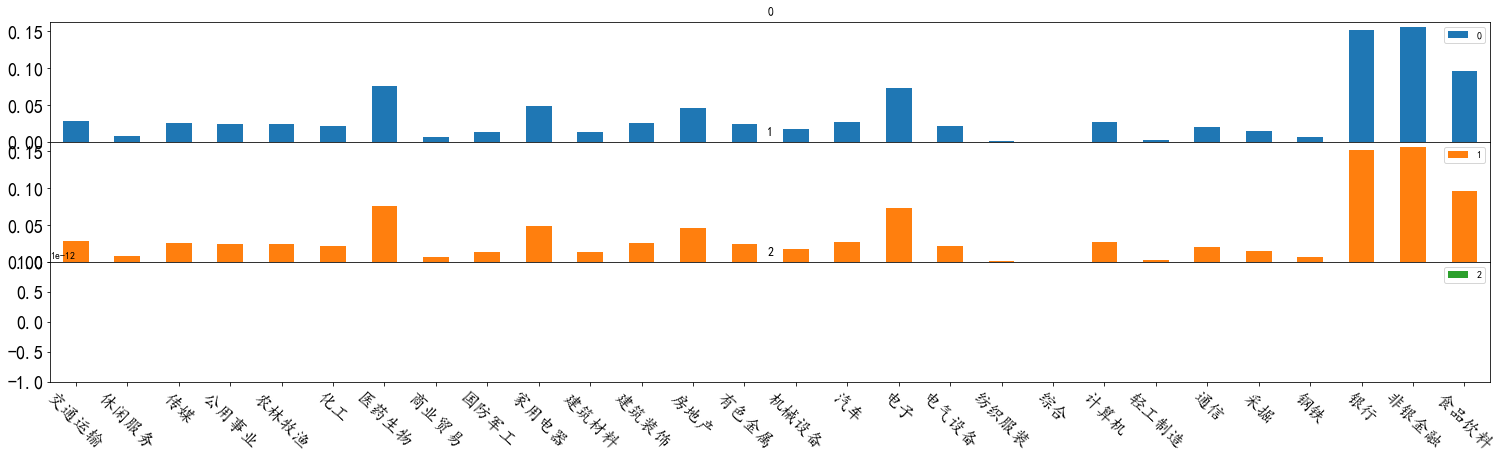

In [273]:
# 行业因子暴漏
xr.loc[b.columns.to_list()].plot.bar(figsize=(20,5),subplots=True,fontsize=18)
plt.xticks(rotation=-45)
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

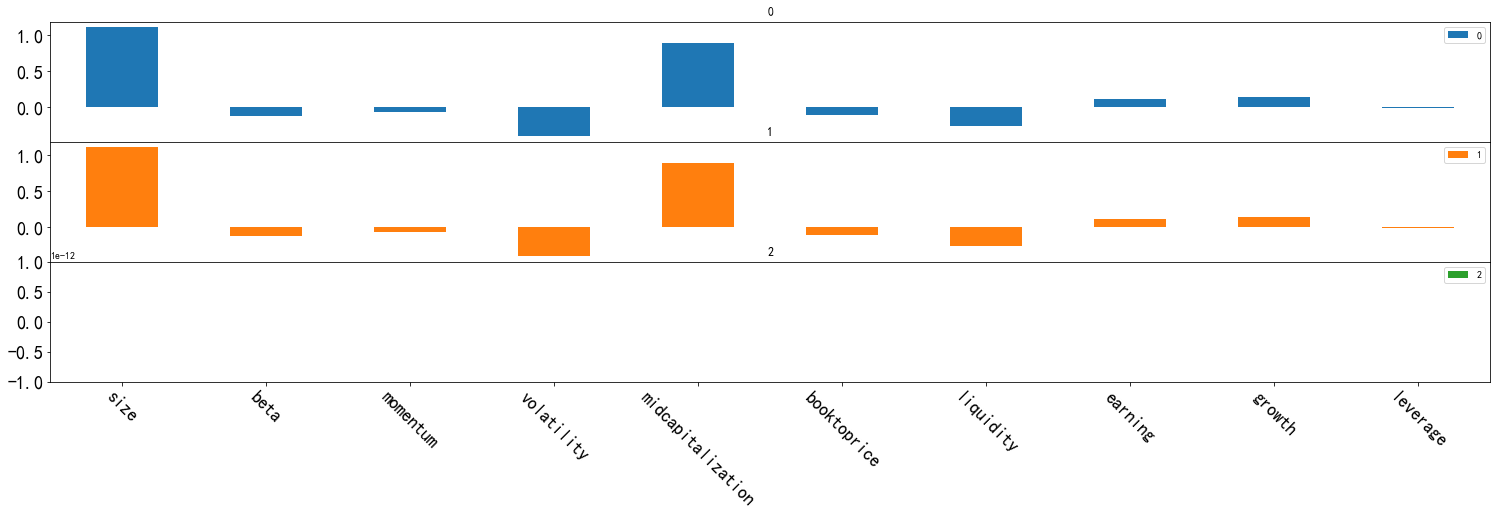

In [274]:
# 风格因子暴漏
xr.loc[list(f0)].plot.bar(figsize=(20,5),subplots=True,fontsize=18)
plt.xticks(rotation=-45)
plt.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

#### 权重分布

##### 个股权重

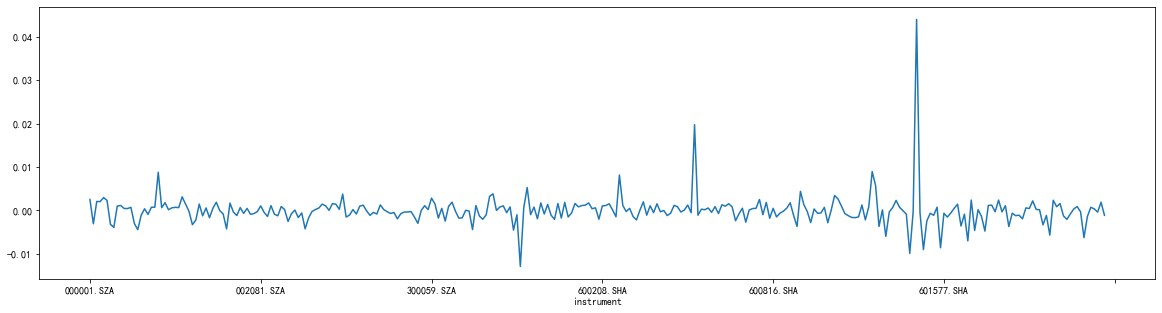

In [277]:
(xh.weight-xh.opt).plot(figsize=(20,5))

##### 行业权重

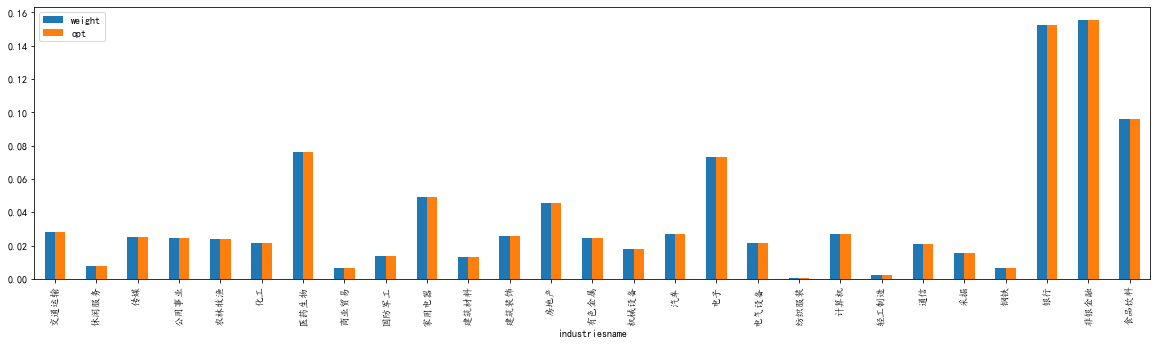

In [278]:
xh.groupby('industriesname').agg({'weight':'sum','opt':'sum'}).plot.bar(figsize=(20,5))

#### 收益分解(归因)

##### 组合收益

In [279]:
xh.loc[:,['weight','opt']].T.values@x.loc[(xt,xc),:]['s_dq_adjclose']

array([-0.014348796604745941, -0.011666939346091362], dtype=object)

##### 因子贡献

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),
 <a list of 39 Text major ticklabel objects>)

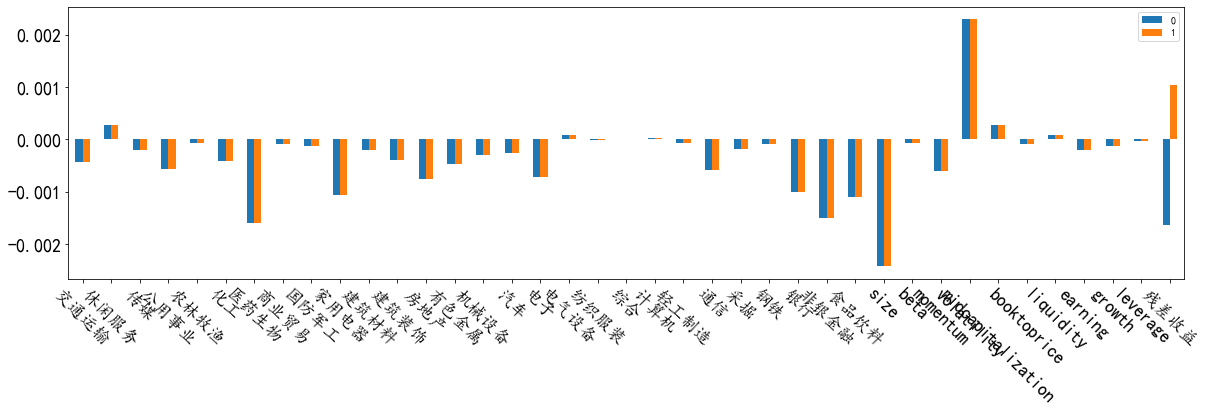

In [280]:
pd.concat(objs=(
    ((xh.loc[:,['weight','opt']].T.values@xx)*xe),# 各因子的收益贡献
    # 残差收益贡献
    pd.DataFrame(data=
        xh.loc[:,['weight','opt']].T.values@x.loc[(xt,xc),:]['s_dq_adjclose']# 组合收益
        -
        (xh.loc[:,['weight','opt']].T.values@xx@xe).values# 因子收益和
             ,columns=['残差收益']),
),axis=1,
).T.plot.bar(figsize=(20,5),fontsize=18)
plt.xticks(rotation=-45)

收益：
1. benchmark收益，系统收益；
2. 主动因子收益；
3. 主动管理收益；